In [5]:
# Mount Google Drive to be able to access files stored there
from google.colab import drive
drive.mount('/drive/')

Mounted at /drive/


In [6]:
import os
# Mount Google Drive
drive.mount('/content/drive')

# Set the directory to your specific folder in Google Drive
folder_path = "/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/"

# Check if the directory exists and print the list of files and folders inside it
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print(files)
else:
    print("Directory does not exist.")

root_dir = "/content/drive/My Drive/" 
# choose where you want your project files to be saved
project_folder = "Colab Notebooks/MMAI 891 NLP/"
os.chdir(root_dir + project_folder)
!pwd

Mounted at /content/drive
['MMAI_891_NLP_Project_ZINDI_Shallow.ipynb', 'Project Brief - Zindi Classification.docx', 'Test.csv', 'Train.csv', 'SampleSubmission.csv', 'MMAI 891 NLP Project ZINDI Deep Learning.ipynb', 'Bert_results.csv', 'Bert_model-1.h5', 'test_predictions.csv', 'cache_dir', 'MODELS', 'ToVaccineOrNotToVaccine-master.zip', 'ToVaccineOrNotVaccine.ipynb', 'projects-portfolio-master', 'submission1.csv', 'Bert_results2.csv', 'Bert_results3.csv', 'Bert_results4.csv', 'Bert_results5.csv', 'zindi_weekendz_nlp_final_solution.ipynb', 'NLP_Primer_twitter_challenge.ipynb', 'Bert_results_new_approach.csv', 'Bert_results_new_approach2.csv', 'Bert_results_new_approach3.csv', 'Bert_results_new_approach_LSTM.csv', 'Bert_results_new_approach_LSTM_cleaned.csv', 'Tara.ipynb', 'Simple_Transformers_Zindi_Irfan_MMAI_891.ipynb', 'MMAI 891 NLP Project ZINDI Shallow ML.ipynb', 'MMAI 891 NLP Project ZINDI Transformes.ipynb', 'Copy of MMAI 891 NLP Project ZINDI Transformes.ipynb', 'MMAI_891_NLP_Pro

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Load the data
train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data
test = pd.read_csv('Test.csv').fillna('') # Read in test
test['label']=0 # We'll fill this in with predictions later
train.head() # Take a peek at the data

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [51]:

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import warnings
seed = 42

warnings.filterwarnings("ignore")

In [52]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to both test and training datasets
train['safe_text'] = train['safe_text'].apply(lambda x: clean_text(x))
# validation_df['safe_text'] = validation_df['safe_text'].apply(lambda x: clean_text(x))
test['safe_text'] = test['safe_text'].apply(lambda x: clean_text(x))

# Let's take a look at the updated text
test['safe_text'].head()

0       amp  a vaccine given  healthy peeps fda thi...
1    students starting school without whooping coug...
2    im kinda over every ep of  being ripped from t...
3    how many innocent children die for lack of vac...
4    cdc eyeing bird flu vaccine for humans though ...
Name: safe_text, dtype: object

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.safe_text, train.label, stratify=train.label, random_state=42, test_size=0.2, shuffle=True)

# TFIDF & BOW & Word2Vec Using Logistic Regression and Naive Bayes

### TFIDF

Tokenize with TFID with ngram = 1,2,3,4,5

Model: Logistic Regression and MultinomialNB

In [203]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train) + list(X_valid))
X_train_ctv =  tfv.transform(X_train) 
X_valid_ctv = tfv.transform(X_valid)
X_test_ctv = tfv.transform(test.safe_text)

In [204]:
n_folds = 10
fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
total_score = 0
TFIDF_test_predictions_probas = []

In [205]:
for i, (train_indices,val_indices) in enumerate(fold.split(X_train_ctv, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_ctv[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_ctv[val_indices], np.take(y_train, val_indices, axis=0)

    # # Training the model
    # model = LogisticRegression(C=1, penalty='l2')
    # model.fit(sub_X_train, sub_y_train)

    model = MultinomialNB()
    model.fit(sub_X_train, sub_y_train)

    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                      for pred in val_predictions_proba]
    score = np.sqrt(mse(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score
    
    # Predicting probabilities using the current model
    TFIDF_test_prediction = model.predict_proba(X_test_ctv)
    TFIDF_test_predictions_probas.append(TFIDF_test_prediction)

print("Average score: {}".format(total_score/n_folds))

Fold 0: 0.6294947893596903
Fold 1: 0.6208917849510526
Fold 2: 0.6088782195016792
Fold 3: 0.611716142552226
Fold 4: 0.6169455023002824
Fold 5: 0.6106366591260738
Fold 6: 0.6009308098572957
Fold 7: 0.6108924364444062
Fold 8: 0.5912821787426794
Fold 9: 0.5986595434813368
Average score: 0.6100328066316721


In [206]:
TFIDF_test_predictions_probas

[array([[0.13093477, 0.32262882, 0.54643641],
        [0.02089023, 0.22649043, 0.75261934],
        [0.07134514, 0.68973306, 0.2389218 ],
        ...,
        [0.05886817, 0.55954165, 0.38159018],
        [0.01700309, 0.0269186 , 0.95607831],
        [0.04789247, 0.48238006, 0.46972746]]),
 array([[0.10696274, 0.29658744, 0.59644982],
        [0.01377093, 0.17270972, 0.81351934],
        [0.07124618, 0.62422928, 0.30452454],
        ...,
        [0.04971401, 0.67194337, 0.27834262],
        [0.02031557, 0.03597841, 0.94370602],
        [0.04386327, 0.53149129, 0.42464544]]),
 array([[0.13251832, 0.2942248 , 0.57325688],
        [0.01581362, 0.18139489, 0.8027915 ],
        [0.06468399, 0.65503897, 0.28027704],
        ...,
        [0.04995668, 0.62471862, 0.3253247 ],
        [0.01634507, 0.03510319, 0.94855174],
        [0.03995004, 0.49165592, 0.46839404]]),
 array([[0.11993148, 0.32733835, 0.55273017],
        [0.01846657, 0.20636194, 0.77517149],
        [0.06726446, 0.61827837, 0.

In [207]:
TFIDF_test_prediction_proba = np.mean(TFIDF_test_predictions_probas, axis=0)
# Converting the probability into its corresponding class
TFIDF_test_prediction_NB = [(pred.argmax()-1)*pred[pred.argmax()] 
                  for pred in TFIDF_test_prediction_proba]

In [208]:
TFIDF_test_prediction_NB

[0.559974171184872,
 0.7911270025201224,
 0.0,
 0.8022717971530124,
 0.0,
 0.5246040977302143,
 0.0,
 0.5342160698539201,
 0.5270626534049243,
 0.4989188812983968,
 0.0,
 0.7897149896072431,
 0.0,
 0.0,
 0.5185921422103994,
 0.6601805159141285,
 0.7119366135634998,
 0.750361930307256,
 0.6872760846920759,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6261459907071927,
 0.0,
 0.5661507465979512,
 0.722983087805615,
 0.0,
 0.7336979905073914,
 0.5860852082160951,
 0.0,
 0.5035666797382099,
 0.7089611005551223,
 0.4814638269475756,
 0.0,
 0.0,
 0.0,
 0.8675183378881727,
 0.0,
 0.0,
 0.0,
 0.8004532979516101,
 0.591270129802723,
 0.8938971403580573,
 0.5543516721950998,
 0.0,
 0.8398505691514314,
 0.9332177770751029,
 0.8105589897676323,
 0.46403184460716107,
 0.0,
 0.5658988911422199,
 0.0,
 0.9360005629907105,
 0.8133461074399234,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6102439028501921,
 0.0,
 0.0,
 0.0,
 0.4854475312387369,
 0.4725177265436086,
 0.6269278325648248,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8

In [209]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission['label'] = TFIDF_test_prediction_NB
print(SampleSubmission)
SampleSubmission.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/TFIDF_ngram2_NB_1.csv', encoding='utf-8', index=False, header=True)

      tweet_id     label
0     00BHHHP1  0.559974
1     00UNMD0E  0.791127
2     01AXPTJF  0.000000
3     01HOEQJW  0.802272
4     01JUKMAO  0.000000
...        ...       ...
5172  ZXVVNC5O  0.955935
5173  ZYIANVI8  0.000000
5174  ZYITEHAH  0.000000
5175  ZZ3BMBTG  0.947657
5176  ZZIYCVNH  0.000000

[5177 rows x 2 columns]


## BOW

Tokenize with bag of words

ngrams=2, we found 2 to be the best in TFIDF.

Model: Logistic Regression

In [57]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 2), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(X_train) + list(X_valid))
X_train_ctv =  ctv.transform(X_train) 
X_valid_ctv = ctv.transform(X_valid)
X_test_ctv = ctv.transform(test.safe_text)

In [58]:
total_score = 0
BOW_test_predictions_probas = []
for i, (train_indices,val_indices) in enumerate(fold.split(X_train_ctv, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_ctv[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_ctv[val_indices], np.take(y_train, val_indices, axis=0)

    # Training the model
    # model = LogisticRegression(C=1, penalty='l2')
    # model.fit(sub_X_train, sub_y_train)

    model = MultinomialNB()
    model.fit(sub_X_train, sub_y_train)

    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                      for pred in val_predictions_proba]
    score = np.sqrt(mse(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score
    
    # Predicting probabilities using the current model
    BOW_test_prediction = model.predict_proba(X_test_ctv)
    BOW_test_predictions_probas.append(BOW_test_prediction)

print("Average score: {}".format(total_score/n_folds))

Fold 0: 0.6976000444727154
Fold 1: 0.6936133690192698
Fold 2: 0.6756787374992245
Fold 3: 0.6626690235325896
Fold 4: 0.6684211624095334
Fold 5: 0.6764825269790868
Fold 6: 0.6620651422213297
Fold 7: 0.6694568545070582
Fold 8: 0.6348718951607559
Fold 9: 0.6247540654495041
Average score: 0.6665612821251068


In [212]:
BOW_test_prediction_proba = np.mean(BOW_test_predictions_probas, axis=0)
# Converting the probability into its corresponding class
BOW_test_prediction_NB = [(pred.argmax()-1)*pred[pred.argmax()] 
                  for pred in BOW_test_prediction_proba]

In [213]:
BOW_test_prediction_proba

array([[1.03076535e-03, 1.56650796e-02, 9.83304155e-01],
       [1.26392849e-05, 2.34992988e-02, 9.76488062e-01],
       [1.94181934e-04, 9.72849565e-01, 2.69562534e-02],
       ...,
       [1.38030684e-05, 9.57457213e-01, 4.25289843e-02],
       [3.38390570e-08, 1.45472598e-07, 9.99999821e-01],
       [1.27334302e-03, 6.17268229e-01, 3.81458428e-01]])

In [214]:
BOW_test_prediction_NB

[0.9833041550450285,
 0.9764880618788844,
 0.0,
 0.9999595874133824,
 0.0,
 0.839424455428927,
 0.0,
 0.9391050404277946,
 0.7463180916109867,
 0.0,
 0.0,
 0.9999715413929552,
 0.5857463149614953,
 0.0,
 0.8044159610981089,
 0.9670043776503313,
 0.9903015664467947,
 0.9957441710086634,
 0.9795162798831102,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9949107142006122,
 0.0,
 0.9392825646685496,
 0.9998691020706154,
 0.0,
 0.9963238942024791,
 0.9071175602837455,
 0.0,
 0.787963991830334,
 0.9423272260143827,
 0.51252921174284,
 0.0,
 0.0,
 0.0,
 0.999994257400363,
 0.0,
 0.0,
 0.0,
 0.9983801283232815,
 0.7692328856974477,
 0.9999980112671707,
 0.9490568893908529,
 0.0,
 0.99992819705238,
 0.9999889127084524,
 0.9999738159729781,
 0.5513723024101604,
 0.0,
 0.6456222785276291,
 0.0,
 0.9999995622802447,
 0.9999930202294662,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9118785762254762,
 0.0,
 0.7302020919071552,
 0.0,
 -0.5125782188696035,
 0.7893482848270902,
 0.9930232320602231,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [215]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission['label'] = BOW_test_prediction_NB
print(SampleSubmission)
SampleSubmission.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/BOW_ngram2_NB_1.csv', encoding='utf-8', index=False, header=True)

      tweet_id     label
0     00BHHHP1  0.983304
1     00UNMD0E  0.976488
2     01AXPTJF  0.000000
3     01HOEQJW  0.999960
4     01JUKMAO  0.000000
...        ...       ...
5172  ZXVVNC5O  0.999997
5173  ZYIANVI8  0.000000
5174  ZYITEHAH  0.000000
5175  ZZ3BMBTG  1.000000
5176  ZZIYCVNH  0.000000

[5177 rows x 2 columns]


## Using Word2Vec

In [60]:
from gensim.models import Word2Vec

# Train Word2Vec model on the corpus of text data
sentences = [text.split() for text in list(X_train) + list(X_valid)]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Define a function to generate document embeddings
def get_doc_embedding(doc):
    # Split the text into individual words
    words = doc.split()

    # Remove out-of-vocabulary words
    words = [word for word in words if word in w2v_model.wv.key_to_index]

    # Compute the mean of the word embeddings
    if len(words) > 0:
        embedding = w2v_model.wv[words].mean(axis=0)
    else:
        embedding = np.zeros(w2v_model.vector_size)
    
    return embedding

# Convert the text data to embeddings using the Word2Vec model
X_train_w2v = np.array([get_doc_embedding(text) for text in X_train])
X_valid_w2v = np.array([get_doc_embedding(text) for text in X_valid])
X_test_w2v = np.array([get_doc_embedding(text) for text in test.safe_text])

n_folds = 10
fold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
total_score = 0
W2V_test_predictions_probas = []
for i, (train_indices,val_indices) in enumerate(fold.split(X_train_w2v, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_w2v[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_w2v[val_indices], np.take(y_train, val_indices, axis=0)

    # Training the model
    model = LogisticRegression(C=1, penalty='l2')
    model.fit(sub_X_train, sub_y_train)

 
    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                      for pred in val_predictions_proba]
    score = np.sqrt(mse(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score
    
    # Predicting probabilities using the current model
    W2V_test_prediction = model.predict_proba(X_test_w2v)
    W2V_test_predictions_probas.append(W2V_test_prediction)

print("Average score: {}".format(total_score/n_folds))


Fold 0: 0.6501112923085782
Fold 1: 0.6421274346411276
Fold 2: 0.6440725638434466
Fold 3: 0.6554285243760675
Fold 4: 0.6378263458673308
Fold 5: 0.6344226563786797
Fold 6: 0.6401338150405376
Fold 7: 0.6407141333332572
Fold 8: 0.646833238951994
Fold 9: 0.651888982549446
Average score: 0.6443558987290465


In [219]:
W2V_test_prediction_proba = np.mean(W2V_test_predictions_probas, axis=0)
# Converting the probability into its corresponding class
W2V_test_prediction = [(pred.argmax()-1)*pred[pred.argmax()] 
                  for pred in W2V_test_prediction_proba]

In [220]:
W2V_test_prediction_proba

array([[0.17315634, 0.3140877 , 0.51275596],
       [0.09965945, 0.51647119, 0.38386936],
       [0.07477158, 0.60556058, 0.31966785],
       ...,
       [0.06629563, 0.52494005, 0.40876432],
       [0.0939572 , 0.13951799, 0.76652481],
       [0.10759063, 0.4330868 , 0.45932257]])

In [221]:
W2V_test_prediction

[0.5127559581501515,
 0.0,
 0.0,
 0.6022054173596622,
 0.0,
 0.4744345442716413,
 0.451864469744723,
 0.655111477519194,
 0.7774077317154786,
 0.0,
 0.0,
 0.6635556991180888,
 0.5410806031870252,
 0.612679228683707,
 0.0,
 0.5472379589157935,
 0.668759352070545,
 0.7254921412799307,
 0.5091760223927506,
 0.5249989602090928,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5628655030252697,
 0.0,
 0.6351583456230904,
 0.6910676947290735,
 0.0,
 0.4304981696606688,
 0.6618727297331943,
 0.0,
 0.0,
 0.5390854865953745,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8316175765205733,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6634593401807586,
 0.4795497427356487,
 0.0,
 0.4661815671076547,
 0.5707623562814799,
 0.810570401724981,
 0.49502219154502125,
 0.0,
 0.0,
 0.0,
 0.8383869729377125,
 0.91834201884168,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.4501064252760262,
 0.0,
 0.0,
 0.5203059712386116,
 0.61301756077504,
 0.5306821162205579,
 0.4902731475746867,
 0.0,
 0.0,
 0.4625167255546908,
 0.0,
 0.0,
 0.48023665265330073,
 0.48933809469771933,
 

In [57]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission['label'] = W2V_test_prediction
print(SampleSubmission)
SampleSubmission.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/W2V_1.csv', encoding='utf-8', index=False, header=True)

      tweet_id     label
0     00BHHHP1  0.492068
1     00UNMD0E  0.000000
2     01AXPTJF  0.000000
3     01HOEQJW  0.618134
4     01JUKMAO  0.000000
...        ...       ...
5172  ZXVVNC5O  0.522018
5173  ZYIANVI8  0.000000
5174  ZYITEHAH  0.000000
5175  ZZ3BMBTG  0.766472
5176  ZZIYCVNH  0.475093

[5177 rows x 2 columns]


# Tree Based Models

LightGBM, XGBoost


## Data Preparation and Visualization

In [7]:
# Load the data
train = pd.read_csv('Train.csv').dropna(0) # Read in train, ignoring one row with missing data
test = pd.read_csv('Test.csv').fillna('') # Read in test
# test['label']=0 # We'll fill this in with predictions later

In [8]:
train=train[train.label.isin([0,1,-1])]
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [9]:
train.append(pd.Series(['RQMQ0L2A','I cannot believe in this day and age some parents could be so oblivious to reality as to not #vaccinate their child. #lawandorderSVU',1,0.666667], index=train.columns ), ignore_index=True)

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.000000
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.000000
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.000000
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.000000
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.000000
...,...,...,...,...
9995,WKKPCJY6,<user> <user> In spite of all measles outbrea...,1.0,0.666667
9996,ST3A265H,Interesting trends in child immunization in Ok...,0.0,1.000000
9997,6Z27IJGD,CDC Says Measles Are At Highest Levels In Deca...,0.0,1.000000
9998,P6190L3Q,Pneumonia vaccine: for women w risk of pulmona...,1.0,0.666667


In [10]:
train['label']=train['label']*train['agreement']

In [11]:
train.isnull().sum()

tweet_id     0
safe_text    0
label        0
agreement    0
dtype: int64

In [12]:
test.iloc[2024]['tweet_id']='E0GRUEO2'
test.iloc[2024]['safe_text']='Dr. JAMES SHANNON'

In [13]:
train.agreement.value_counts()

1.000000    5866
0.666667    3894
0.333333     239
Name: agreement, dtype: int64

In [14]:
test.isnull().sum()

tweet_id     0
safe_text    0
dtype: int64

In [15]:
import re
import nltk
from nltk.corpus import stopwords



from bs4 import BeautifulSoup



def url_to_words(raw_text):
    raw_text=str(raw_text).strip()
    soup = BeautifulSoup(raw_text, 'html.parser')
    raw_text = soup.text
    no_coms=re.sub(r'\.com','',raw_text)
    no_urls=re.sub('https?://www','',no_coms)
    no_urls1=re.sub('https?://','',no_urls)
    try:
        no_encoding=no_urls1.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        no_encoding = no_urls1
    letters_only = re.sub("[^a-zA-Z]", " ",no_encoding) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

In [16]:
test

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."
...,...,...
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. wha...
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time sin...
5174,ZYITEHAH,<user> issues alert regarding Measles in TX. K...
5175,ZZ3BMBTG,I can't believe people don't vaccinate their k...


In [17]:
df=train[['tweet_id','safe_text','label']].append(test,ignore_index=True)

In [18]:
df

,tweet_id,safe_text,label
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0
...,...,...,...
15171,ZXVVNC5O,jenny mccarthy is on new years rockin eve. wha...,NaN
15172,ZYIANVI8,Measles reported in Clark Co. for 1st time sin...,NaN
15173,ZYITEHAH,<user> issues alert regarding Measles in TX. K...,NaN
15174,ZZ3BMBTG,I can't believe people don't vaccinate their k...,NaN


In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
import string
punctuation=string.punctuation
df['safe_text']=df['safe_text'].astype('category')
df['word_count']=df['safe_text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['safe_text'].str.len()

def avg_word(sentence):
    words = sentence.split()
    if len(words) > 0:
        return (sum(len(word) for word in words)/len(words))
    else:
        return 0


# def avg_word(sentence):
#     words = sentence.split()
#     return (sum(len(word) for word in words)/len(words))

df['avg_word'] = df['safe_text'].apply(lambda x: avg_word(x))
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['stopwords'] = df['safe_text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['numerics'] = df['safe_text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df['upper'] = df['safe_text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df['word_density'] = df['char_count'] / (df['word_count']+1)
df['punctuation_count'] = df['safe_text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
df['hastag_count'] = df['safe_text'].apply(lambda x: len("".join(_ for _ in x if _=="#"))) 

In [21]:
df.head()

,tweet_id,safe_text,label,word_count,char_count,avg_word,stopwords,numerics,upper,word_density,punctuation_count,hastag_count
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,15,90,5.066667,0,0,5,5.625000,11,5
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,25,140,4.640000,8,0,1,5.384615,4,0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,7,55,7.000000,0,0,6,6.875000,2,1
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,28,138,3.964286,15,0,2,4.758621,4,0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,20,106,4.350000,4,1,1,5.047619,8,2


In [22]:
col=['word_count', 'char_count',
       'avg_word', 'stopwords', 'numerics', 'upper', 'word_density',
       'punctuation_count', 'hastag_count']

In [23]:
df_train=df[df.label.isnull()==False]
df_test=df[df.label.isnull()==True]
print(df_train.shape,df_test.shape)

(9999, 12) (5177, 12)


In [24]:
print(df_train['safe_text'].sample(20,random_state=20).values)
df_test['safe_text'].sample(20,random_state=20).values

['I hear <user> on MMR with <user> 😃', 'Where's <user> "<user> Why you should vaccina..., '<user> Have you seen the research that suppor..., '<user> <user>  1980 had my Son vaccinated.He ..., '<user> MADDEN MOBILE COINS FOR SALE FROM A MM..., ..., 'People who refuse immunization's for there ch..., 'Princeton Measles Case Confirmed: A suspected..., '<user> <user>  allergies, asthma, autism, aut..., 'Disney measles outbreak: Resort asks staff fo..., 'I won't but I could fill my feed with case af...]
Length: 20
Categories (14584, object): ['', '!!!!! RT <user> Hand-washing could save more ...,
                             '" #PTI #ImranKhan <user> \n#MissionImranKhanW..., '" Got That #FOD2 🙌🙌 Make Sure Y'all Hit <user...,
                             ..., '😷😷😷😷 “<user> Five Disneyland employees have b...,
                             '😻🐶Vaccinations are an important part in ensur..., '🙌 MT <user> The science is clear: The earth i...,
                             '🚨 LINK IN MY BIO 🚨 Just d

['Girl fighting for life after measles complica..., '#shutdown and health: #4 CDC will stop fundin..., 'This Vaccine Is Gonna Be The Death Of Me', 'Great“<user> <user> officials: <user> student..., 'To the Parent of the Unvaccinated Child Who E..., ..., 'REAL EYES REALIZE  REAL LIES. The Food, vacci..., '“<user> The science is clear: The earth is ro..., 'Vaccination story shares spiked during measle..., 'Parents who don't believe in vaccinating your..., '<user> <user> <user> Totally agree. As a pare...]
Length: 20
Categories (14584, object): ['', '!!!!! RT <user> Hand-washing could save more ...,
                             '" #PTI #ImranKhan <user> \n#MissionImranKhanW..., '" Got That #FOD2 🙌🙌 Make Sure Y'all Hit <user...,
                             ..., '😷😷😷😷 “<user> Five Disneyland employees have b...,
                             '😻🐶Vaccinations are an important part in ensur..., '🙌 MT <user> The science is clear: The earth i...,
                             '🚨 LINK IN MY BIO 🚨 

In [25]:
from tqdm import tqdm
tqdm.pandas()
df_train['safe_text']=df_train['safe_text'].progress_apply(url_to_words)
df_test['safe_text']=df_test['safe_text'].progress_apply(url_to_words)

100%|██████████| 5177/5177 [00:03<00:00, 1472.10it/s]


In [26]:
print(df_train['safe_text'].sample(20,random_state=20).values)
df_test['safe_text'].sample(20,random_state=20).values

['hear mmr' 'vaccinate kids two minutes'
 'seen research supports measles vaccine cure form blood cancer alley'
 'son vaccinated became ill never autistic diagnosis sure still wonder'
 'madden mobile coins sale mmr pro member legit player anyone interested follow n dm thank'
 'measles cases us cases far deaths r u encouraging false hysteria cdcwhistleblower'
 'hope get measles fucking registering wait room fucking joke eat shit comiccon'
 'vaccines lyme diseases way protect get bitten' 'called heard immunity'
 'sight mind rich white folks vaccinating kids makes go'
 'jenny mccarthy slippery new vaccine stance child mind institute goodread'
 'dumbasses measles outbreak'
 'vaccinations singapore hope get typhoid fever singaporebound kendall county health human services'
 'despicable katie couric casts lot jenny mccarthy rest vaccine truthers'
 'get vaccinated folks mother facebook updates detail son tragic death pertussis'
 'people refuse immunization children uneducated especially say h

array(['girl fighting life measles complications please vaccinate children',
       'shutdown health cdc stop funding annual flu vaccine program tracking disease outbreaks people could die',
       'vaccine gonna death',
       'great officials student w measles rode bart last week exposing potentially thousands disease',
       'parent unvaccinated child exposed family measles via',
       'puss haha scared vaccines poor baby spoiled sillykitty spruce avenue pet hospital',
       'measles case confirmed tarrant county texas person flew dfw india via dubai health measles',
       'sb new schools providing immunity liability offering certain elective course effective date emerg',
       'loling sit next anti vaxers call getting vaccines fear mongering hippies become doomsday preppers',
       'man vaccinations debate hysterical many idiots vaccines gave child diabetus lol ok nutbags move island',
       'duval county health department immunization center jacksonville fl',
       'one fi

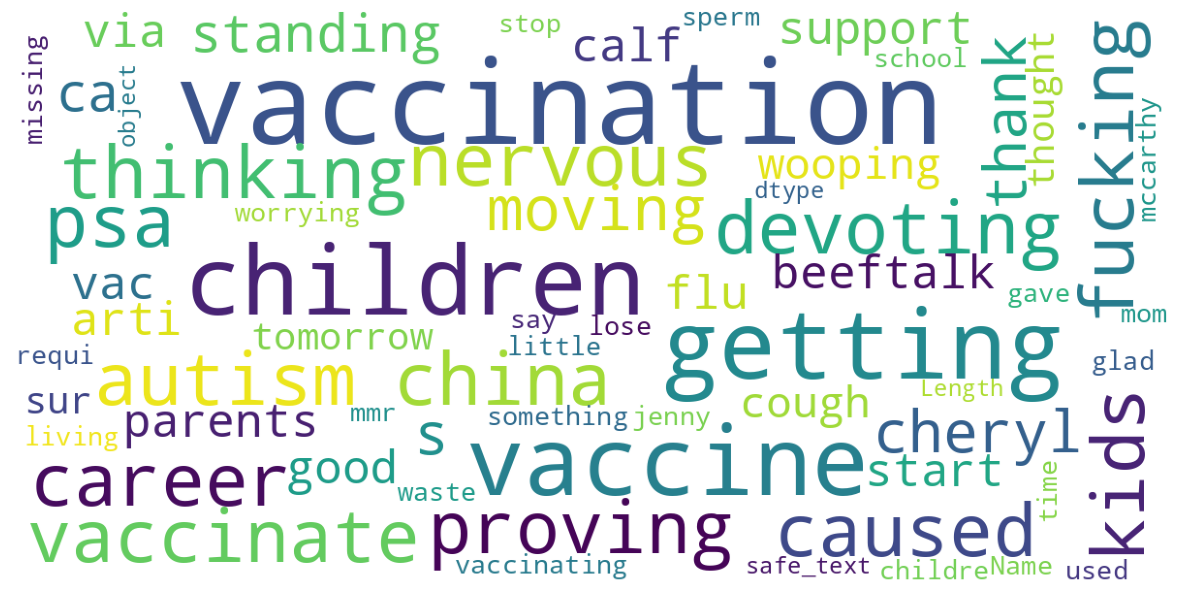

In [27]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df_train[df_train.label==1]['safe_text'])

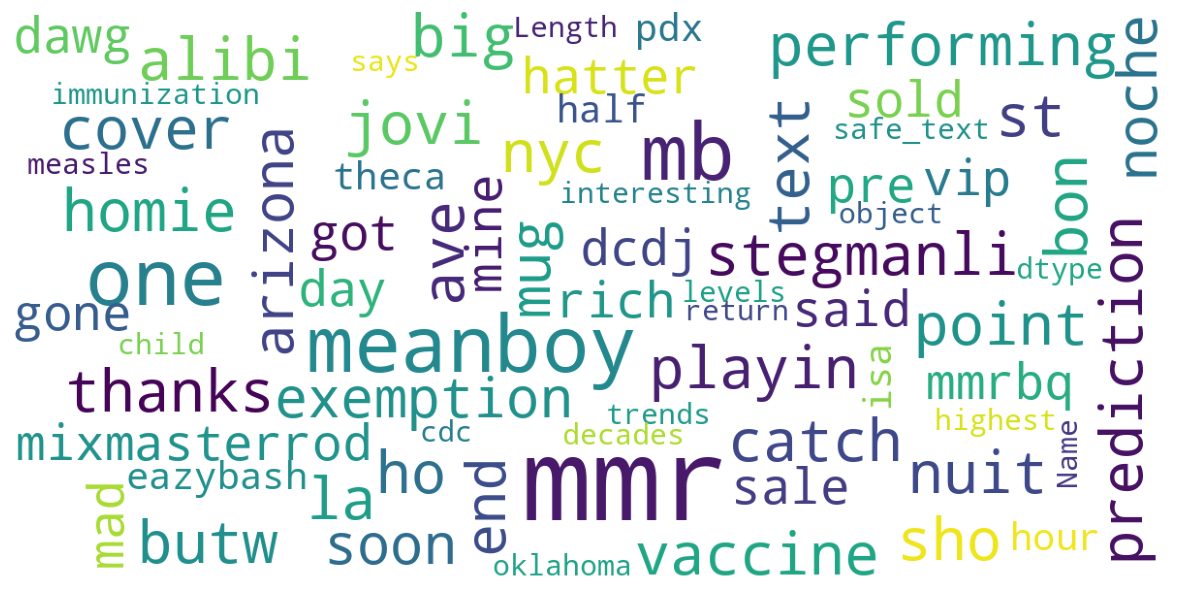

In [28]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df_train[df_train.label==0]['safe_text'])

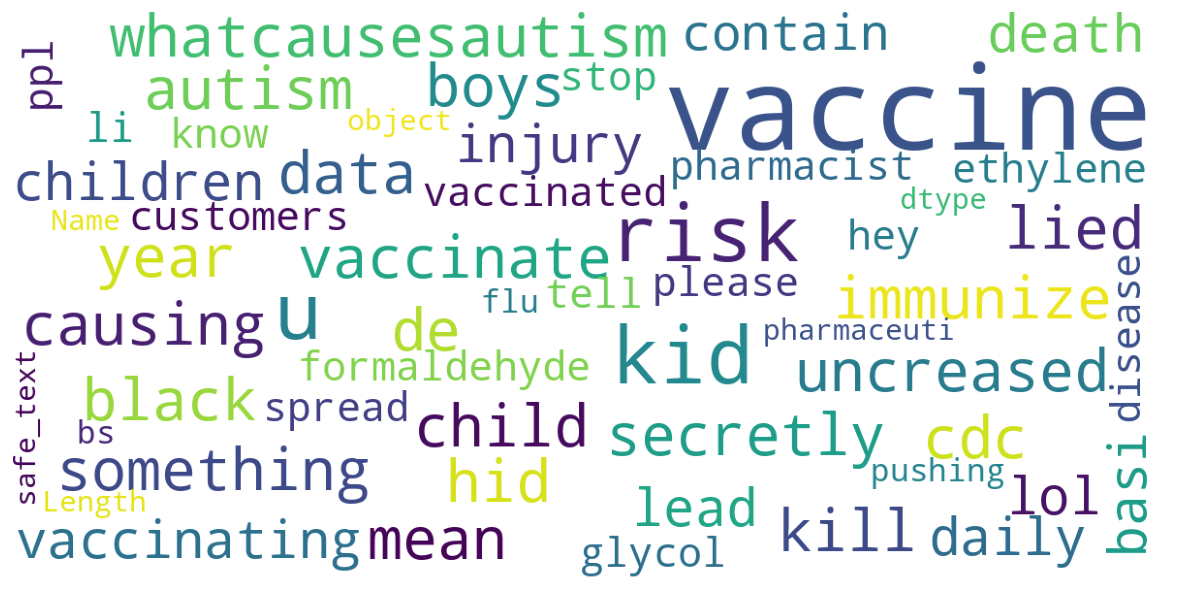

In [29]:
from wordcloud import WordCloud, STOPWORDS
stopwords1 = set(STOPWORDS)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords1,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df_train[df_train.label==-1]['safe_text'])

## Modeling

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,f1_score,mean_squared_error
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
v_name = TfidfVectorizer(ngram_range=(1,2),stop_words="english", analyzer='word')
name_tr =v_name.fit_transform(df_train['safe_text'])
name_ts =v_name.transform(df_test['safe_text'])

In [41]:
from scipy.sparse import csr_matrix
from scipy import sparse
final_features = sparse.hstack((df_train[col],name_tr )).tocsr()
final_featurest = sparse.hstack((df_test[col],name_ts)).tocsr()

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.metrics import accuracy_score,f1_score,mean_squared_error,mean_squared_log_error,log_loss
X=final_features
# y=pd.get_dummies(train_df['Labels'].values)
y=df_train.label
X_train,X_val,y_train,y_val = train_test_split(X, y, stratify=y, 
                                                  random_state=1994, 
                                                  test_size=0.25, shuffle=True)

In [43]:
y_bin=pd.qcut(df_train.label,3,labels=False)

In [ ]:
# obtuna results, not much improvement.so dropped using it.
{'max_depth': 4, 'learning_rate': 0.018213203347664637, 'n_estimators': 1479, 'num_leaves': 43, 'min_child_weight': 2.092756071026953, 'subsample': 0.83721309025916, 'reg_alpha': 0.5986731220196322, 'reg_lambda': 0.5761672724556144}

In [44]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# m=LGBMRegressor(n_estimators=6000,random_state=1994,learning_rate=0.03)

m=XGBRegressor(n_estimators=10000,random_state=1994,learning_rate=0.2
,colsample_bytree=0.4,max_depth=3)

# m=XGBRegressor(n_estimators=1479,random_state=1994,learning_rate=0.018213203347664637,
#                colsample_bytree=0.4,max_depth=4, num_leaves = 43, min_child_weight = 2.092756071026953,
#                subsample = 0.83721309025916, reg_alpha = 0.5986731220196322, reg_lambda = 0.5761672724556144)

m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val, y_val.values)], early_stopping_rounds=100,verbose=1,eval_metric='rmse')
p=m.predict(X_val)
print(np.sqrt(mean_squared_error(y_val.values,p)))

[0]	validation_0-rmse:0.56508	validation_1-rmse:0.56656
[1]	validation_0-rmse:0.54593	validation_1-rmse:0.54811
[2]	validation_0-rmse:0.53546	validation_1-rmse:0.53931
[3]	validation_0-rmse:0.52369	validation_1-rmse:0.52899
[4]	validation_0-rmse:0.51732	validation_1-rmse:0.52372
[5]	validation_0-rmse:0.51147	validation_1-rmse:0.51851
[6]	validation_0-rmse:0.50627	validation_1-rmse:0.51400
[7]	validation_0-rmse:0.50158	validation_1-rmse:0.51052
[8]	validation_0-rmse:0.49848	validation_1-rmse:0.50835
[9]	validation_0-rmse:0.49600	validation_1-rmse:0.50651
[10]	validation_0-rmse:0.49331	validation_1-rmse:0.50463
[11]	validation_0-rmse:0.49117	validation_1-rmse:0.50303
[12]	validation_0-rmse:0.48917	validation_1-rmse:0.50182
[13]	validation_0-rmse:0.48709	validation_1-rmse:0.50053
[14]	validation_0-rmse:0.48487	validation_1-rmse:0.49904
[15]	validation_0-rmse:0.48346	validation_1-rmse:0.49864
[16]	validation_0-rmse:0.48206	validation_1-rmse:0.49838
[17]	validation_0-rmse:0.48086	validation

In [45]:
from sklearn.model_selection import KFold,StratifiedKFold

errcat = []
y_pred_totcat = []

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1994)

for train_index, test_index in fold.split(X,y_bin):
    X_train, X_test = X[train_index], X[test_index]
#     X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # cat = LGBMRegressor(n_estimators=6000,random_state=1994,learning_rate=0.03)
    cat = XGBRegressor(n_estimators=6000,random_state=1994,learning_rate=0.03,colsample_bytree=0.4,max_depth=5)
    cat.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)], verbose=300, early_stopping_rounds=200,eval_metric='rmse')

    y_pred_cat = cat.predict(X_test)
    print("RMSE: ", np.sqrt(mean_squared_error(y_test.values,y_pred_cat)))

    errcat.append(np.sqrt(mean_squared_error(y_test.values,y_pred_cat)))
    p = cat.predict(final_featurest)
    y_pred_totcat.append(p)

[0]	validation_0-rmse:0.58352	validation_1-rmse:0.58309
[300]	validation_0-rmse:0.42971	validation_1-rmse:0.47510
[600]	validation_0-rmse:0.39900	validation_1-rmse:0.46909
[900]	validation_0-rmse:0.37640	validation_1-rmse:0.46643
[1200]	validation_0-rmse:0.35766	validation_1-rmse:0.46487
[1500]	validation_0-rmse:0.34236	validation_1-rmse:0.46366
[1726]	validation_0-rmse:0.33181	validation_1-rmse:0.46381
RMSE:  0.46357723390489847
[0]	validation_0-rmse:0.58560	validation_1-rmse:0.57465
[300]	validation_0-rmse:0.43098	validation_1-rmse:0.46610
[600]	validation_0-rmse:0.40106	validation_1-rmse:0.45943
[900]	validation_0-rmse:0.37966	validation_1-rmse:0.45693
[1200]	validation_0-rmse:0.36169	validation_1-rmse:0.45580
[1500]	validation_0-rmse:0.34641	validation_1-rmse:0.45542
[1800]	validation_0-rmse:0.33291	validation_1-rmse:0.45535
[2100]	validation_0-rmse:0.32123	validation_1-rmse:0.45492
[2400]	validation_0-rmse:0.30980	validation_1-rmse:0.45470
[2481]	validation_0-rmse:0.30677	validati

In [47]:
np.mean(errcat)

0.4634926751300803

In [48]:
np.mean(y_pred_totcat,0)

array([-0.23548242,  0.5045135 ,  0.14085345, ...,  0.28235686,
        1.2152134 ,  0.08142103], dtype=float32)

In [173]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission['label'] = np.mean(y_pred_totcat,0)
print(SampleSubmission)
SampleSubmission.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/lightgbm_1.csv', encoding='utf-8', index=False, header=True)

      tweet_id     label
0     00BHHHP1  0.207273
1     00UNMD0E  0.285006
2     01AXPTJF  0.091619
3     01HOEQJW  0.843092
4     01JUKMAO  0.076392
...        ...       ...
5172  ZXVVNC5O  0.799920
5173  ZYIANVI8  0.190224
5174  ZYITEHAH  0.300409
5175  ZZ3BMBTG  0.869594
5176  ZZIYCVNH  0.179603

[5177 rows x 2 columns]


In [49]:
SampleSubmission = pd.read_csv('SampleSubmission.csv')
SampleSubmission['label'] = np.mean(y_pred_totcat,0)
print(SampleSubmission)
SampleSubmission.to_csv('/content/drive/My Drive/Colab Notebooks/MMAI 891 NLP/xgboost_depth10_ngram2_1.csv', encoding='utf-8', index=False, header=True)

      tweet_id     label
0     00BHHHP1 -0.235482
1     00UNMD0E  0.504514
2     01AXPTJF  0.140853
3     01HOEQJW  0.500122
4     01JUKMAO  0.109236
...        ...       ...
5172  ZXVVNC5O  0.998614
5173  ZYIANVI8  0.085690
5174  ZYITEHAH  0.282357
5175  ZZ3BMBTG  1.215213
5176  ZZIYCVNH  0.081421

[5177 rows x 2 columns]


In [188]:
SampleSubmission['label'].describe()

count    5177.000000
mean        0.286637
std         0.274108
min        -1.391390
25%         0.092903
50%         0.242092
75%         0.466945
max         1.284484
Name: label, dtype: float64

### Adding Hyper Paramet Tuning

In [ ]:
!pip install optuna

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import load_wine
import optuna

In [251]:
X_hyp=final_features
# y=pd.get_dummies(train_df['Labels'].values)
y_hyp=df_train.label
X_train_hyp,X_val_hyp,y_train_hyp,y_val_hyp = train_test_split(X, y, stratify=y, 
                                                  random_state=1994, 
                                                  test_size=0.25, shuffle=True)

In [249]:
y_hyp_bin=pd.qcut(df_train.label,3,labels=False)

In [258]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# m=LGBMRegressor(n_estimators=6000,random_state=1994,learning_rate=0.03)

m=XGBRegressor(n_estimators=10000,random_state=1994,learning_rate=0.2
,colsample_bytree=0.4,max_depth=3)

m.fit(X_train_hyp,y_train_hyp,eval_set=[(X_train_hyp,y_train_hyp),(X_val_hyp, y_val_hyp.values)], early_stopping_rounds=100,verbose=1,eval_metric='rmse')
p=m.predict(X_val_hyp)
print(np.sqrt(mean_squared_error(y_val_hyp.values,p)))

[0]	validation_0-rmse:0.56098	validation_1-rmse:0.56267
[1]	validation_0-rmse:0.54278	validation_1-rmse:0.54600
[2]	validation_0-rmse:0.53000	validation_1-rmse:0.53436
[3]	validation_0-rmse:0.52230	validation_1-rmse:0.52764
[4]	validation_0-rmse:0.51477	validation_1-rmse:0.52070
[5]	validation_0-rmse:0.50931	validation_1-rmse:0.51605
[6]	validation_0-rmse:0.50509	validation_1-rmse:0.51337
[7]	validation_0-rmse:0.50212	validation_1-rmse:0.51062
[8]	validation_0-rmse:0.49887	validation_1-rmse:0.50896
[9]	validation_0-rmse:0.49620	validation_1-rmse:0.50745
[10]	validation_0-rmse:0.49433	validation_1-rmse:0.50609
[11]	validation_0-rmse:0.49192	validation_1-rmse:0.50431
[12]	validation_0-rmse:0.49029	validation_1-rmse:0.50285
[13]	validation_0-rmse:0.48823	validation_1-rmse:0.50178
[14]	validation_0-rmse:0.48654	validation_1-rmse:0.50082
[15]	validation_0-rmse:0.48492	validation_1-rmse:0.49970
[16]	validation_0-rmse:0.48327	validation_1-rmse:0.49828
[17]	validation_0-rmse:0.48162	validation

In [266]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.4),
        'n_estimators': trial.suggest_int('n_estimators', 10, 10000),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_child_weight': trial.suggest_float('min_child_weight', .001, 20),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'rmse',
        'use_label_encoder': False,
        'is_unbalance':True,
    }

    # Fit the model
    optuna_model = XGBRegressor(**params)
    optuna_model.fit(X_train_hyp,y_train_hyp)

    # Make predictions
    y_pred = optuna_model.predict(X_val_hyp)

    # Evaluate predictions
    p = optuna_model.predict(X_val_hyp)
    rmse = np.sqrt(mean_squared_error(y_val_hyp.values, p))
    return rmse

In [267]:
study = optuna.create_study(direction='minimize')

[I 2023-04-14 16:54:33,540] A new study created in memory with name: no-name-41bd43ce-9f08-4ec6-9184-23d319deaf94


In [ ]:
#Commented optuna run cell, the results are in the next cell.
study.optimize(objective, n_trials=1500)

[16:54:34] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 16:56:45,304] Trial 0 finished with value: 0.5340368800673968 and parameters: {'max_depth': 3, 'learning_rate': 0.27894706017086285, 'n_estimators': 7692, 'num_leaves': 24, 'min_child_weight': 6.946151131988516, 'subsample': 0.8898656348096179, 'reg_alpha': 0.44496620241648605, 'reg_lambda': 0.8248138520275269}. Best is trial 0 with value: 0.5340368800673968.


[16:56:45] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 16:57:11,038] Trial 1 finished with value: 0.5360766881559599 and parameters: {'max_depth': 5, 'learning_rate': 0.3578726663543192, 'n_estimators': 1144, 'num_leaves': 27, 'min_child_weight': 6.892899258095107, 'subsample': 0.5692371095620142, 'reg_alpha': 0.7093543457523703, 'reg_lambda': 0.6580127733343171}. Best is trial 0 with value: 0.5340368800673968.


[16:57:11] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 16:58:28,344] Trial 2 finished with value: 0.47457364171032973 and parameters: {'max_depth': 5, 'learning_rate': 0.018479216805217514, 'n_estimators': 2849, 'num_leaves': 47, 'min_child_weight': 0.6453274920882327, 'subsample': 0.5660620374237657, 'reg_alpha': 0.986253690020729, 'reg_lambda': 0.9482489162108734}. Best is trial 2 with value: 0.47457364171032973.


[16:58:28] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:00:06,388] Trial 3 finished with value: 0.5239462235496218 and parameters: {'max_depth': 2, 'learning_rate': 0.17772211563373266, 'n_estimators': 9960, 'num_leaves': 25, 'min_child_weight': 1.0753904592678294, 'subsample': 0.4881846677217266, 'reg_alpha': 0.9462145145935654, 'reg_lambda': 0.437275660770559}. Best is trial 2 with value: 0.47457364171032973.


[17:00:06] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:00:57,141] Trial 4 finished with value: 0.8102893630062099 and parameters: {'max_depth': 3, 'learning_rate': 0.3723201489030982, 'n_estimators': 5261, 'num_leaves': 19, 'min_child_weight': 6.4700570897794805, 'subsample': 0.11854989465629145, 'reg_alpha': 0.9237724391740445, 'reg_lambda': 0.14216984457782678}. Best is trial 2 with value: 0.47457364171032973.


[17:00:57] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:01:46,171] Trial 5 finished with value: 0.5285699123360513 and parameters: {'max_depth': 2, 'learning_rate': 0.09334120124222849, 'n_estimators': 9910, 'num_leaves': 26, 'min_child_weight': 13.222547897820325, 'subsample': 0.10269800905482093, 'reg_alpha': 0.3779765723764096, 'reg_lambda': 0.1809184195395453}. Best is trial 2 with value: 0.47457364171032973.


[17:01:46] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:03:05,308] Trial 6 finished with value: 0.5025474812325874 and parameters: {'max_depth': 3, 'learning_rate': 0.03691361514617473, 'n_estimators': 7571, 'num_leaves': 30, 'min_child_weight': 10.871547871759226, 'subsample': 0.33209933785249424, 'reg_alpha': 0.058046719503766685, 'reg_lambda': 0.05666487738304671}. Best is trial 2 with value: 0.47457364171032973.


[17:03:05] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:04:43,576] Trial 7 finished with value: 0.519147911811951 and parameters: {'max_depth': 5, 'learning_rate': 0.37964533358108404, 'n_estimators': 3718, 'num_leaves': 43, 'min_child_weight': 3.3137696804531935, 'subsample': 0.9577966547633169, 'reg_alpha': 0.36143052218174393, 'reg_lambda': 0.5390344018460687}. Best is trial 2 with value: 0.47457364171032973.


[17:04:43] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:05:49,226] Trial 8 finished with value: 0.5496193682312618 and parameters: {'max_depth': 4, 'learning_rate': 0.17111919126522468, 'n_estimators': 4908, 'num_leaves': 16, 'min_child_weight': 3.6137406839001756, 'subsample': 0.23528984083616006, 'reg_alpha': 0.9544067138398592, 'reg_lambda': 0.8379999173444317}. Best is trial 2 with value: 0.47457364171032973.


[17:05:49] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:07:37,333] Trial 9 finished with value: 0.6243199027431489 and parameters: {'max_depth': 5, 'learning_rate': 0.2772736967716474, 'n_estimators': 7223, 'num_leaves': 47, 'min_child_weight': 2.7874719644968695, 'subsample': 0.225940718232351, 'reg_alpha': 0.14241927412095828, 'reg_lambda': 0.10125184464945235}. Best is trial 2 with value: 0.47457364171032973.


[17:07:37] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:07:44,236] Trial 10 finished with value: 0.5091597085758748 and parameters: {'max_depth': 4, 'learning_rate': 0.004982911627204533, 'n_estimators': 291, 'num_leaves': 2, 'min_child_weight': 16.23415171301019, 'subsample': 0.6996285094428973, 'reg_alpha': 0.6693168287701045, 'reg_lambda': 0.9915736313353363}. Best is trial 2 with value: 0.47457364171032973.


[17:07:44] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:08:14,583] Trial 11 finished with value: 0.47908897915426574 and parameters: {'max_depth': 3, 'learning_rate': 0.015904684892313198, 'n_estimators': 2535, 'num_leaves': 38, 'min_child_weight': 11.10671663193469, 'subsample': 0.4102109899692925, 'reg_alpha': 0.018185975843310886, 'reg_lambda': 0.35392541473455763}. Best is trial 2 with value: 0.47457364171032973.


[17:08:14] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:08:44,257] Trial 12 finished with value: 0.4978309158807747 and parameters: {'max_depth': 4, 'learning_rate': 0.07674731714668867, 'n_estimators': 2116, 'num_leaves': 39, 'min_child_weight': 18.77164999231993, 'subsample': 0.4327927976068283, 'reg_alpha': 0.21942198250657888, 'reg_lambda': 0.32528910124872706}. Best is trial 2 with value: 0.47457364171032973.


[17:08:44] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:09:28,769] Trial 13 finished with value: 0.4757741596879679 and parameters: {'max_depth': 3, 'learning_rate': 0.015135171455054332, 'n_estimators': 2763, 'num_leaves': 36, 'min_child_weight': 0.4636561438042204, 'subsample': 0.6597843567083783, 'reg_alpha': 0.024858397566863873, 'reg_lambda': 0.3509132615690754}. Best is trial 2 with value: 0.47457364171032973.


[17:09:28] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:10:50,115] Trial 14 finished with value: 0.5025601787520382 and parameters: {'max_depth': 4, 'learning_rate': 0.09997597632961515, 'n_estimators': 3534, 'num_leaves': 50, 'min_child_weight': 0.16068977606370716, 'subsample': 0.6524547658262312, 'reg_alpha': 0.5848427155502586, 'reg_lambda': 0.5738569614708976}. Best is trial 2 with value: 0.47457364171032973.


[17:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:11:52,463] Trial 15 finished with value: 0.4905672705508414 and parameters: {'max_depth': 2, 'learning_rate': 0.059018818104927984, 'n_estimators': 5171, 'num_leaves': 37, 'min_child_weight': 0.35656951814800275, 'subsample': 0.7465568074761213, 'reg_alpha': 0.200096194294754, 'reg_lambda': 0.2785491760048173}. Best is trial 2 with value: 0.47457364171032973.


[17:11:52] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:12:46,651] Trial 16 finished with value: 0.5102590763875176 and parameters: {'max_depth': 5, 'learning_rate': 0.13561248450995186, 'n_estimators': 2244, 'num_leaves': 34, 'min_child_weight': 5.0825671726435315, 'subsample': 0.5797768333305726, 'reg_alpha': 0.7770199002127262, 'reg_lambda': 0.6846089862835583}. Best is trial 2 with value: 0.47457364171032973.


[17:12:46] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:14:03,204] Trial 17 finished with value: 0.47453487420972235 and parameters: {'max_depth': 4, 'learning_rate': 0.004674553369902787, 'n_estimators': 3689, 'num_leaves': 44, 'min_child_weight': 2.165878151230433, 'subsample': 0.7784899684981916, 'reg_alpha': 0.5198869898210257, 'reg_lambda': 0.45095348384711004}. Best is trial 17 with value: 0.47453487420972235.


[17:14:03] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:15:42,080] Trial 18 finished with value: 0.4984810477183811 and parameters: {'max_depth': 5, 'learning_rate': 0.053684740741281975, 'n_estimators': 4199, 'num_leaves': 45, 'min_child_weight': 8.472858570682428, 'subsample': 0.8033771568644743, 'reg_alpha': 0.8288311824317407, 'reg_lambda': 0.4447155815274697}. Best is trial 17 with value: 0.47453487420972235.


[17:15:42] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:17:53,110] Trial 19 finished with value: 0.5116055329267569 and parameters: {'max_depth': 4, 'learning_rate': 0.12886914008252062, 'n_estimators': 6152, 'num_leaves': 42, 'min_child_weight': 4.8213612395355145, 'subsample': 0.8333527610694434, 'reg_alpha': 0.5858438358311013, 'reg_lambda': 0.962934779783872}. Best is trial 17 with value: 0.47453487420972235.


[17:17:53] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:18:29,114] Trial 20 finished with value: 0.47997795468596793 and parameters: {'max_depth': 5, 'learning_rate': 0.005958314952630106, 'n_estimators': 1205, 'num_leaves': 6, 'min_child_weight': 2.193906486803074, 'subsample': 0.7574618298482817, 'reg_alpha': 0.8163422677459973, 'reg_lambda': 0.6151743430970456}. Best is trial 17 with value: 0.47453487420972235.


[17:18:29] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:19:15,238] Trial 21 finished with value: 0.48052797575111955 and parameters: {'max_depth': 3, 'learning_rate': 0.038673106098124056, 'n_estimators': 2904, 'num_leaves': 50, 'min_child_weight': 0.02085525164464208, 'subsample': 0.6458962641743102, 'reg_alpha': 0.291718834088882, 'reg_lambda': 0.4141374124743841}. Best is trial 17 with value: 0.47453487420972235.


[17:19:15] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:19:45,074] Trial 22 finished with value: 0.47875844101402576 and parameters: {'max_depth': 4, 'learning_rate': 0.04557802820046192, 'n_estimators': 1437, 'num_leaves': 35, 'min_child_weight': 2.2310562202694957, 'subsample': 0.6161937542355591, 'reg_alpha': 0.5408490627768979, 'reg_lambda': 0.5055761696595197}. Best is trial 17 with value: 0.47453487420972235.


[17:19:45] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:20:32,077] Trial 23 finished with value: 0.49176271698213875 and parameters: {'max_depth': 3, 'learning_rate': 0.0014821962224580952, 'n_estimators': 3550, 'num_leaves': 41, 'min_child_weight': 2.004900673449052, 'subsample': 0.5271174406551207, 'reg_alpha': 0.5112159886887523, 'reg_lambda': 0.24958512091155283}. Best is trial 17 with value: 0.47453487420972235.


[17:20:32] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:20:38,131] Trial 24 finished with value: 0.47835922981366635 and parameters: {'max_depth': 4, 'learning_rate': 0.07051546378931763, 'n_estimators': 177, 'num_leaves': 31, 'min_child_weight': 4.242719402795511, 'subsample': 0.7165626825697166, 'reg_alpha': 0.43448170669917247, 'reg_lambda': 0.3776806793811516}. Best is trial 17 with value: 0.47453487420972235.


[17:20:38] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:21:50,361] Trial 25 finished with value: 0.4803538728182791 and parameters: {'max_depth': 3, 'learning_rate': 0.02596028663724616, 'n_estimators': 4508, 'num_leaves': 46, 'min_child_weight': 1.7934496716518895, 'subsample': 0.6721689317735962, 'reg_alpha': 0.31239826044728947, 'reg_lambda': 0.489213753214917}. Best is trial 17 with value: 0.47453487420972235.


[17:21:50] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:24:11,907] Trial 26 finished with value: 0.501708197687068 and parameters: {'max_depth': 4, 'learning_rate': 0.09817315028890977, 'n_estimators': 6088, 'num_leaves': 33, 'min_child_weight': 1.263497229453737, 'subsample': 0.8428626398856072, 'reg_alpha': 0.6455960220978477, 'reg_lambda': 0.19651803302846665}. Best is trial 17 with value: 0.47453487420972235.


[17:24:11] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:25:27,758] Trial 27 finished with value: 0.48291682809579917 and parameters: {'max_depth': 5, 'learning_rate': 0.0315479565543144, 'n_estimators': 3230, 'num_leaves': 47, 'min_child_weight': 3.906340985855837, 'subsample': 0.5899179989332245, 'reg_alpha': 0.9871313258346741, 'reg_lambda': 0.33543137194059613}. Best is trial 17 with value: 0.47453487420972235.


[17:25:27] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:25:47,749] Trial 28 finished with value: 0.4745887350005747 and parameters: {'max_depth': 2, 'learning_rate': 0.06810913063424108, 'n_estimators': 1705, 'num_leaves': 40, 'min_child_weight': 5.455738204418767, 'subsample': 0.9941338560693189, 'reg_alpha': 0.45727004989337383, 'reg_lambda': 0.27138930512242737}. Best is trial 17 with value: 0.47453487420972235.


[17:25:47] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:26:05,419] Trial 29 finished with value: 0.4749309952659992 and parameters: {'max_depth': 2, 'learning_rate': 0.06786356594947762, 'n_estimators': 1781, 'num_leaves': 41, 'min_child_weight': 5.585533103982526, 'subsample': 0.9902056337970064, 'reg_alpha': 0.45376334076556013, 'reg_lambda': 0.7476813388722009}. Best is trial 17 with value: 0.47453487420972235.


[17:26:05] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:27:34,005] Trial 30 finished with value: 0.5103313056780339 and parameters: {'max_depth': 2, 'learning_rate': 0.11692598001706254, 'n_estimators': 8652, 'num_leaves': 18, 'min_child_weight': 7.867750760717406, 'subsample': 0.9085680352830448, 'reg_alpha': 0.4566105894589509, 'reg_lambda': 0.5731516405558573}. Best is trial 17 with value: 0.47453487420972235.


[17:27:34] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:27:53,985] Trial 31 finished with value: 0.47436185614332693 and parameters: {'max_depth': 2, 'learning_rate': 0.06286624865719222, 'n_estimators': 1619, 'num_leaves': 42, 'min_child_weight': 5.562425177787656, 'subsample': 0.9857664652206477, 'reg_alpha': 0.46398335659687573, 'reg_lambda': 0.7758034094234778}. Best is trial 31 with value: 0.47436185614332693.


[17:27:54] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:28:06,445] Trial 32 finished with value: 0.4762521382144446 and parameters: {'max_depth': 2, 'learning_rate': 0.054505452498399554, 'n_estimators': 779, 'num_leaves': 44, 'min_child_weight': 5.418853890511699, 'subsample': 0.9219099226464084, 'reg_alpha': 0.7168235835452004, 'reg_lambda': 0.8890494685272968}. Best is trial 31 with value: 0.47436185614332693.


[17:28:06] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:28:24,272] Trial 33 finished with value: 0.4756095756496179 and parameters: {'max_depth': 2, 'learning_rate': 0.07819963198538228, 'n_estimators': 1760, 'num_leaves': 50, 'min_child_weight': 3.1966057697817605, 'subsample': 0.9963599368031586, 'reg_alpha': 0.529989203122758, 'reg_lambda': 0.7583104612309622}. Best is trial 31 with value: 0.47436185614332693.


[17:28:24] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:28:29,335] Trial 34 finished with value: 0.48345320375285333 and parameters: {'max_depth': 2, 'learning_rate': 0.027755827552274022, 'n_estimators': 667, 'num_leaves': 40, 'min_child_weight': 6.230728620104388, 'subsample': 0.8647030639338561, 'reg_alpha': 0.585420028405343, 'reg_lambda': 0.9325548096234918}. Best is trial 31 with value: 0.47436185614332693.


[17:28:29] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:28:54,670] Trial 35 finished with value: 0.4759062059336085 and parameters: {'max_depth': 2, 'learning_rate': 0.03727226933328355, 'n_estimators': 2387, 'num_leaves': 29, 'min_child_weight': 6.865184725670205, 'subsample': 0.9090773009959197, 'reg_alpha': 0.8842186611513166, 'reg_lambda': 0.8597718227698269}. Best is trial 31 with value: 0.47436185614332693.


[17:28:54] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:29:41,054] Trial 36 finished with value: 0.48886425233841985 and parameters: {'max_depth': 2, 'learning_rate': 0.08180080094440001, 'n_estimators': 4324, 'num_leaves': 47, 'min_child_weight': 4.298651750097456, 'subsample': 0.7934373188045424, 'reg_alpha': 0.38674862620805256, 'reg_lambda': 0.9422371296488345}. Best is trial 31 with value: 0.47436185614332693.


[17:29:41] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:30:05,996] Trial 37 finished with value: 0.474549827671737 and parameters: {'max_depth': 3, 'learning_rate': 0.056648945594629546, 'n_estimators': 1490, 'num_leaves': 44, 'min_child_weight': 2.959734011719731, 'subsample': 0.9591815067397075, 'reg_alpha': 0.4869693758401699, 'reg_lambda': 0.7682589350891253}. Best is trial 31 with value: 0.47436185614332693.


[17:30:06] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:30:25,564] Trial 38 finished with value: 0.4784999267051981 and parameters: {'max_depth': 3, 'learning_rate': 0.10505304935674012, 'n_estimators': 1047, 'num_leaves': 22, 'min_child_weight': 1.2728672010476236, 'subsample': 0.878186736019275, 'reg_alpha': 0.7276689796054139, 'reg_lambda': 0.7904580114245922}. Best is trial 31 with value: 0.47436185614332693.


[17:30:25] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:31:32,314] Trial 39 finished with value: 0.48017356232590286 and parameters: {'max_depth': 3, 'learning_rate': 0.05173245363761678, 'n_estimators': 4014, 'num_leaves': 12, 'min_child_weight': 2.95622204336524, 'subsample': 0.958897057062063, 'reg_alpha': 0.866199453187429, 'reg_lambda': 0.8152740321492685}. Best is trial 31 with value: 0.47436185614332693.


[17:31:32] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:33:02,287] Trial 40 finished with value: 0.47992963243125625 and parameters: {'max_depth': 5, 'learning_rate': 0.0022664313396890123, 'n_estimators': 3252, 'num_leaves': 43, 'min_child_weight': 2.8314258228668114, 'subsample': 0.7811609102441496, 'reg_alpha': 0.9495530234277936, 'reg_lambda': 0.6758966325800495}. Best is trial 31 with value: 0.47436185614332693.


[17:33:02] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:33:20,487] Trial 41 finished with value: 0.47529243852202346 and parameters: {'max_depth': 2, 'learning_rate': 0.025889364828790316, 'n_estimators': 1880, 'num_leaves': 44, 'min_child_weight': 4.100945384420793, 'subsample': 0.9566215257477512, 'reg_alpha': 0.4948281603687211, 'reg_lambda': 0.8785685050572514}. Best is trial 31 with value: 0.47436185614332693.


[17:33:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:33:43,224] Trial 42 finished with value: 0.47771614835031934 and parameters: {'max_depth': 2, 'learning_rate': 0.08291181859441442, 'n_estimators': 1503, 'num_leaves': 48, 'min_child_weight': 1.4618151199394118, 'subsample': 0.8776259402504633, 'reg_alpha': 0.4172369652682876, 'reg_lambda': 0.9997902601758806}. Best is trial 31 with value: 0.47436185614332693.


[17:33:43] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:34:25,916] Trial 43 finished with value: 0.479522263880566 and parameters: {'max_depth': 3, 'learning_rate': 0.05698382951013285, 'n_estimators': 2786, 'num_leaves': 38, 'min_child_weight': 5.757715238529875, 'subsample': 0.9970392993526923, 'reg_alpha': 0.48310909875977415, 'reg_lambda': 0.7192124244346276}. Best is trial 31 with value: 0.47436185614332693.


[17:34:25] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:34:26,426] Trial 44 finished with value: 0.5336374207772507 and parameters: {'max_depth': 4, 'learning_rate': 0.021401666404507767, 'n_estimators': 27, 'num_leaves': 40, 'min_child_weight': 2.8479880701280607, 'subsample': 0.9356735967554676, 'reg_alpha': 0.360032002592979, 'reg_lambda': 0.6358977023779612}. Best is trial 31 with value: 0.47436185614332693.


[17:34:26] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:34:33,674] Trial 45 finished with value: 0.47701389986568854 and parameters: {'max_depth': 3, 'learning_rate': 0.14716712338216553, 'n_estimators': 612, 'num_leaves': 45, 'min_child_weight': 3.6472990977897997, 'subsample': 0.8306402433885246, 'reg_alpha': 0.6552963548219383, 'reg_lambda': 0.7644407820748715}. Best is trial 31 with value: 0.47436185614332693.


[17:34:33] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:35:43,314] Trial 46 finished with value: 0.5023671965960351 and parameters: {'max_depth': 5, 'learning_rate': 0.21629915230814745, 'n_estimators': 2345, 'num_leaves': 48, 'min_child_weight': 1.1019840956437943, 'subsample': 0.8866114039075552, 'reg_alpha': 0.6076686932435703, 'reg_lambda': 0.8221813903429237}. Best is trial 31 with value: 0.47436185614332693.


[17:35:43] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:36:05,402] Trial 47 finished with value: 0.4786129272690099 and parameters: {'max_depth': 4, 'learning_rate': 0.08661551346399839, 'n_estimators': 1016, 'num_leaves': 32, 'min_child_weight': 5.129884872602777, 'subsample': 0.9501610804986809, 'reg_alpha': 0.9985967422028553, 'reg_lambda': 0.0015845343744713691}. Best is trial 31 with value: 0.47436185614332693.


[17:36:05] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:36:38,438] Trial 48 finished with value: 0.47988972640660704 and parameters: {'max_depth': 2, 'learning_rate': 0.042718067311340355, 'n_estimators': 3182, 'num_leaves': 28, 'min_child_weight': 6.633067191828589, 'subsample': 0.7416281437416633, 'reg_alpha': 0.532285352100052, 'reg_lambda': 0.6988427940760081}. Best is trial 31 with value: 0.47436185614332693.


[17:36:38] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:38:04,288] Trial 49 finished with value: 0.4985024916560528 and parameters: {'max_depth': 3, 'learning_rate': 0.06426108733115976, 'n_estimators': 5823, 'num_leaves': 36, 'min_child_weight': 7.782552393212558, 'subsample': 0.8216214570513458, 'reg_alpha': 0.41114880766585327, 'reg_lambda': 0.8910490507124278}. Best is trial 31 with value: 0.47436185614332693.


[17:38:04] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:38:54,118] Trial 50 finished with value: 0.47338311244657955 and parameters: {'max_depth': 4, 'learning_rate': 0.018017944934617374, 'n_estimators': 1992, 'num_leaves': 38, 'min_child_weight': 0.5576506562921077, 'subsample': 0.9003267243036684, 'reg_alpha': 0.47299091858177705, 'reg_lambda': 0.6535197966026143}. Best is trial 50 with value: 0.47338311244657955.


[17:38:54] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:39:36,748] Trial 51 finished with value: 0.4726653221454429 and parameters: {'max_depth': 4, 'learning_rate': 0.012014078169324087, 'n_estimators': 2009, 'num_leaves': 42, 'min_child_weight': 2.21314847605631, 'subsample': 0.913127824467753, 'reg_alpha': 0.4852781064527174, 'reg_lambda': 0.7217951186965748}. Best is trial 51 with value: 0.4726653221454429.


[17:39:36] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:40:32,084] Trial 52 finished with value: 0.4738627402258853 and parameters: {'max_depth': 4, 'learning_rate': 0.009807758439329007, 'n_estimators': 2112, 'num_leaves': 43, 'min_child_weight': 0.9298780804531498, 'subsample': 0.9091202289914966, 'reg_alpha': 0.5417918598898711, 'reg_lambda': 0.658123617096423}. Best is trial 51 with value: 0.4726653221454429.


[17:40:32] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:41:35,731] Trial 53 finished with value: 0.47272716283440264 and parameters: {'max_depth': 4, 'learning_rate': 0.014525603643520933, 'n_estimators': 2603, 'num_leaves': 42, 'min_child_weight': 0.4502863019248205, 'subsample': 0.9112388373269411, 'reg_alpha': 0.5618518055027162, 'reg_lambda': 0.6517568757979698}. Best is trial 51 with value: 0.4726653221454429.


[17:41:35] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:42:29,561] Trial 54 finished with value: 0.4729855237343393 and parameters: {'max_depth': 4, 'learning_rate': 0.015600559620038238, 'n_estimators': 2074, 'num_leaves': 42, 'min_child_weight': 0.6641834981304776, 'subsample': 0.8504836370703243, 'reg_alpha': 0.5588659574358948, 'reg_lambda': 0.6622440017705908}. Best is trial 51 with value: 0.4726653221454429.


[17:42:29] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:43:20,157] Trial 55 finished with value: 0.47261765321603194 and parameters: {'max_depth': 4, 'learning_rate': 0.01777137890226379, 'n_estimators': 2089, 'num_leaves': 38, 'min_child_weight': 0.4989433927056636, 'subsample': 0.8578392204526132, 'reg_alpha': 0.5720534529611475, 'reg_lambda': 0.639430031353344}. Best is trial 55 with value: 0.47261765321603194.


[17:43:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:44:11,816] Trial 56 finished with value: 0.47337419079714965 and parameters: {'max_depth': 4, 'learning_rate': 0.015697212477918693, 'n_estimators': 2110, 'num_leaves': 38, 'min_child_weight': 0.7535773713289589, 'subsample': 0.8594006410013451, 'reg_alpha': 0.5632365387975459, 'reg_lambda': 0.6267362142288961}. Best is trial 55 with value: 0.47261765321603194.


[17:44:11] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:45:14,230] Trial 57 finished with value: 0.47290816162634297 and parameters: {'max_depth': 4, 'learning_rate': 0.014716625222277773, 'n_estimators': 2570, 'num_leaves': 38, 'min_child_weight': 0.11557851289531779, 'subsample': 0.8496690432969808, 'reg_alpha': 0.622638133716487, 'reg_lambda': 0.6156925289253942}. Best is trial 55 with value: 0.47261765321603194.


[17:45:14] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:46:20,702] Trial 58 finished with value: 0.48002011784590704 and parameters: {'max_depth': 4, 'learning_rate': 0.038926706841308015, 'n_estimators': 2609, 'num_leaves': 34, 'min_child_weight': 0.19777753831295397, 'subsample': 0.8534325331921359, 'reg_alpha': 0.6238650598833423, 'reg_lambda': 0.6139200291485292}. Best is trial 55 with value: 0.47261765321603194.


[17:46:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:47:34,652] Trial 59 finished with value: 0.4744614032603169 and parameters: {'max_depth': 4, 'learning_rate': 0.01664574778120776, 'n_estimators': 3001, 'num_leaves': 25, 'min_child_weight': 0.8762224816995224, 'subsample': 0.8521123213670057, 'reg_alpha': 0.5649456125155619, 'reg_lambda': 0.7059451124352881}. Best is trial 55 with value: 0.47261765321603194.


[17:47:34] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:49:21,360] Trial 60 finished with value: 0.48310480398655775 and parameters: {'max_depth': 4, 'learning_rate': 0.0015792565778020937, 'n_estimators': 4775, 'num_leaves': 36, 'min_child_weight': 1.834475304847694, 'subsample': 0.8069668868997718, 'reg_alpha': 0.6728330431238408, 'reg_lambda': 0.5972681890704963}. Best is trial 55 with value: 0.47261765321603194.


[17:49:21] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:50:19,904] Trial 61 finished with value: 0.47318179510693004 and parameters: {'max_depth': 4, 'learning_rate': 0.017383917604951924, 'n_estimators': 2297, 'num_leaves': 38, 'min_child_weight': 0.029240086603493753, 'subsample': 0.8948927287328758, 'reg_alpha': 0.5577405896969543, 'reg_lambda': 0.6398085022688522}. Best is trial 55 with value: 0.47261765321603194.


[17:50:19] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:51:20,285] Trial 62 finished with value: 0.4782309292661357 and parameters: {'max_depth': 4, 'learning_rate': 0.03297742121231343, 'n_estimators': 2414, 'num_leaves': 38, 'min_child_weight': 0.08568969679169758, 'subsample': 0.8697018087256605, 'reg_alpha': 0.5989480520420506, 'reg_lambda': 0.5530338427405168}. Best is trial 55 with value: 0.47261765321603194.


[17:51:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:52:50,725] Trial 63 finished with value: 0.4764201848339591 and parameters: {'max_depth': 4, 'learning_rate': 0.019021303373366334, 'n_estimators': 3868, 'num_leaves': 39, 'min_child_weight': 0.7515450388990783, 'subsample': 0.8204769483504681, 'reg_alpha': 0.5704481546248462, 'reg_lambda': 0.6304674552359205}. Best is trial 55 with value: 0.47261765321603194.


[17:52:50] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:53:18,191] Trial 64 finished with value: 0.47686165222441396 and parameters: {'max_depth': 4, 'learning_rate': 0.04647576063213893, 'n_estimators': 1214, 'num_leaves': 37, 'min_child_weight': 0.03624613121552056, 'subsample': 0.766081537929529, 'reg_alpha': 0.6240378985530507, 'reg_lambda': 0.5908966696407929}. Best is trial 55 with value: 0.47261765321603194.


[17:53:18] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:54:37,290] Trial 65 finished with value: 0.4732228425138571 and parameters: {'max_depth': 4, 'learning_rate': 0.015054497735099148, 'n_estimators': 3439, 'num_leaves': 34, 'min_child_weight': 2.1756706166801076, 'subsample': 0.9340902834274326, 'reg_alpha': 0.5547460368244571, 'reg_lambda': 0.7284947328268465}. Best is trial 55 with value: 0.47261765321603194.


[17:54:37] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:55:51,983] Trial 66 finished with value: 0.4792338435571556 and parameters: {'max_depth': 4, 'learning_rate': 0.02906279397290057, 'n_estimators': 3426, 'num_leaves': 34, 'min_child_weight': 2.2453216686606474, 'subsample': 0.915897669387786, 'reg_alpha': 0.5090672616344301, 'reg_lambda': 0.6788514675460122}. Best is trial 55 with value: 0.47261765321603194.


[17:55:52] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:56:54,515] Trial 67 finished with value: 0.48008979815762515 and parameters: {'max_depth': 4, 'learning_rate': 0.04402321072564849, 'n_estimators': 2715, 'num_leaves': 31, 'min_child_weight': 1.2966600394808494, 'subsample': 0.9299400095318203, 'reg_alpha': 0.6870373059000222, 'reg_lambda': 0.7315966453676102}. Best is trial 55 with value: 0.47261765321603194.


[17:56:54] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:57:59,293] Trial 68 finished with value: 0.473030518782558 and parameters: {'max_depth': 4, 'learning_rate': 0.011272908482527159, 'n_estimators': 2911, 'num_leaves': 41, 'min_child_weight': 1.8038902421437153, 'subsample': 0.7997009307723886, 'reg_alpha': 0.617848042051816, 'reg_lambda': 0.7156757257668005}. Best is trial 55 with value: 0.47261765321603194.


[17:57:59] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:59:02,706] Trial 69 finished with value: 0.48659665679412195 and parameters: {'max_depth': 4, 'learning_rate': 0.0019131588507451391, 'n_estimators': 3007, 'num_leaves': 42, 'min_child_weight': 1.6466654218924965, 'subsample': 0.7963714616611045, 'reg_alpha': 0.6384310277911182, 'reg_lambda': 0.5321991072750805}. Best is trial 55 with value: 0.47261765321603194.


[17:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 17:59:56,879] Trial 70 finished with value: 0.4769404398666475 and parameters: {'max_depth': 4, 'learning_rate': 0.030257309434480243, 'n_estimators': 2513, 'num_leaves': 41, 'min_child_weight': 2.443512647992873, 'subsample': 0.7213644074836065, 'reg_alpha': 0.5940021785414344, 'reg_lambda': 0.6660237960983193}. Best is trial 55 with value: 0.47261765321603194.


[17:59:56] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:01:20,005] Trial 71 finished with value: 0.4736937601941143 and parameters: {'max_depth': 4, 'learning_rate': 0.013141860609478162, 'n_estimators': 3584, 'num_leaves': 35, 'min_child_weight': 1.8483066521159435, 'subsample': 0.8870617253263324, 'reg_alpha': 0.5547341266555531, 'reg_lambda': 0.726002047656441}. Best is trial 55 with value: 0.47261765321603194.


[18:01:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:02:09,044] Trial 72 finished with value: 0.4724858879535597 and parameters: {'max_depth': 4, 'learning_rate': 0.013464465103312659, 'n_estimators': 2060, 'num_leaves': 40, 'min_child_weight': 0.7105962829940624, 'subsample': 0.8389184276955265, 'reg_alpha': 0.5206073983029406, 'reg_lambda': 0.7078602659038077}. Best is trial 72 with value: 0.4724858879535597.


[18:02:09] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:02:56,376] Trial 73 finished with value: 0.4751622301512158 and parameters: {'max_depth': 4, 'learning_rate': 0.028669949067353373, 'n_estimators': 2155, 'num_leaves': 40, 'min_child_weight': 0.8149849193923754, 'subsample': 0.8099580899760257, 'reg_alpha': 0.5153907366637355, 'reg_lambda': 0.6860808888715714}. Best is trial 72 with value: 0.4724858879535597.


[18:02:56] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:03:26,307] Trial 74 finished with value: 0.47315220858788337 and parameters: {'max_depth': 4, 'learning_rate': 0.04015601762647507, 'n_estimators': 1235, 'num_leaves': 42, 'min_child_weight': 1.4093049977920562, 'subsample': 0.8313573943908138, 'reg_alpha': 0.6180145096622894, 'reg_lambda': 0.6403243686889618}. Best is trial 72 with value: 0.4724858879535597.


[18:03:26] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:04:00,213] Trial 75 finished with value: 0.4740191145676177 and parameters: {'max_depth': 4, 'learning_rate': 0.03831091944446649, 'n_estimators': 1479, 'num_leaves': 46, 'min_child_weight': 1.5105466086923078, 'subsample': 0.838297476286582, 'reg_alpha': 0.6039247329608357, 'reg_lambda': 0.6898870801278887}. Best is trial 72 with value: 0.4724858879535597.


[18:04:00] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:04:19,946] Trial 76 finished with value: 0.4751876029110911 and parameters: {'max_depth': 4, 'learning_rate': 0.04895082171343781, 'n_estimators': 1128, 'num_leaves': 45, 'min_child_weight': 3.4369342076689433, 'subsample': 0.7638402452084189, 'reg_alpha': 0.6367863494682721, 'reg_lambda': 0.6016327874413181}. Best is trial 72 with value: 0.4724858879535597.


[18:04:19] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:04:59,352] Trial 77 finished with value: 0.4820522235468952 and parameters: {'max_depth': 4, 'learning_rate': 0.07172458191519399, 'n_estimators': 1740, 'num_leaves': 42, 'min_child_weight': 2.555432749738483, 'subsample': 0.7915605224876971, 'reg_alpha': 0.6975974632194709, 'reg_lambda': 0.6472770838489269}. Best is trial 72 with value: 0.4724858879535597.


[18:04:59] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:05:14,534] Trial 78 finished with value: 0.500474712608561 and parameters: {'max_depth': 5, 'learning_rate': 0.0033232610822596705, 'n_estimators': 517, 'num_leaves': 41, 'min_child_weight': 0.5597575708367647, 'subsample': 0.8403339359061968, 'reg_alpha': 0.6691152471423824, 'reg_lambda': 0.7040489659167969}. Best is trial 72 with value: 0.4724858879535597.


[18:05:14] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:05:30,555] Trial 79 finished with value: 0.47379822662798593 and parameters: {'max_depth': 4, 'learning_rate': 0.02684421984607034, 'n_estimators': 812, 'num_leaves': 49, 'min_child_weight': 1.4474611030148035, 'subsample': 0.7441241867034837, 'reg_alpha': 0.504703012600072, 'reg_lambda': 0.7433940871079963}. Best is trial 72 with value: 0.4724858879535597.


[18:05:30] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:05:59,473] Trial 80 finished with value: 0.47689220325931475 and parameters: {'max_depth': 4, 'learning_rate': 0.010536421901714103, 'n_estimators': 1258, 'num_leaves': 43, 'min_child_weight': 3.3071490523996565, 'subsample': 0.8628029816589421, 'reg_alpha': 0.5816641288858854, 'reg_lambda': 0.5751176670208177}. Best is trial 72 with value: 0.4724858879535597.


[18:05:59] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:06:44,250] Trial 81 finished with value: 0.4744211368958393 and parameters: {'max_depth': 4, 'learning_rate': 0.023762718132749244, 'n_estimators': 1934, 'num_leaves': 39, 'min_child_weight': 0.4580894939447895, 'subsample': 0.8926348278770393, 'reg_alpha': 0.5400185377578106, 'reg_lambda': 0.6495771357216248}. Best is trial 72 with value: 0.4724858879535597.


[18:06:44] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:07:46,917] Trial 82 finished with value: 0.4728423483652554 and parameters: {'max_depth': 4, 'learning_rate': 0.010960950076076972, 'n_estimators': 2615, 'num_leaves': 37, 'min_child_weight': 0.07468217115284193, 'subsample': 0.8251511469995274, 'reg_alpha': 0.6086885444770732, 'reg_lambda': 0.6132934749657216}. Best is trial 72 with value: 0.4724858879535597.


[18:07:47] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:08:48,516] Trial 83 finished with value: 0.47864794908740316 and parameters: {'max_depth': 4, 'learning_rate': 0.03653832525146394, 'n_estimators': 2694, 'num_leaves': 41, 'min_child_weight': 1.3063398375435096, 'subsample': 0.838642794170772, 'reg_alpha': 0.6068725108804317, 'reg_lambda': 0.7892283879894659}. Best is trial 72 with value: 0.4724858879535597.


[18:08:48] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:09:49,181] Trial 84 finished with value: 0.48560654165044004 and parameters: {'max_depth': 4, 'learning_rate': 0.04997562619581573, 'n_estimators': 2982, 'num_leaves': 36, 'min_child_weight': 1.9304704941996755, 'subsample': 0.7749015058188226, 'reg_alpha': 0.6235263469994843, 'reg_lambda': 0.6189318042573987}. Best is trial 72 with value: 0.4724858879535597.


[18:09:49] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:13:20,558] Trial 85 finished with value: 0.47661865318974983 and parameters: {'max_depth': 4, 'learning_rate': 0.008617801190492328, 'n_estimators': 9511, 'num_leaves': 46, 'min_child_weight': 1.0163646111442257, 'subsample': 0.8192879241771895, 'reg_alpha': 0.6534251335870889, 'reg_lambda': 0.6667639390208213}. Best is trial 72 with value: 0.4724858879535597.


[18:13:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:14:03,864] Trial 86 finished with value: 0.48170304889272625 and parameters: {'max_depth': 4, 'learning_rate': 0.05756806831271133, 'n_estimators': 1951, 'num_leaves': 43, 'min_child_weight': 2.604451542451497, 'subsample': 0.7924208836148168, 'reg_alpha': 0.5161514000297368, 'reg_lambda': 0.7045780254205221}. Best is trial 72 with value: 0.4724858879535597.


[18:14:03] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:15:02,097] Trial 87 finished with value: 0.47949962017614667 and parameters: {'max_depth': 4, 'learning_rate': 0.035293552075514864, 'n_estimators': 2505, 'num_leaves': 40, 'min_child_weight': 0.5083033313699558, 'subsample': 0.8724286226094571, 'reg_alpha': 0.4865665350636499, 'reg_lambda': 0.5839986698369265}. Best is trial 72 with value: 0.4724858879535597.


[18:15:02] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:15:34,538] Trial 88 finished with value: 0.47456389746273436 and parameters: {'max_depth': 4, 'learning_rate': 0.02447196857119692, 'n_estimators': 1686, 'num_leaves': 37, 'min_child_weight': 1.7371265441222405, 'subsample': 0.6955213170561324, 'reg_alpha': 0.5816457306633374, 'reg_lambda': 0.5443955542317044}. Best is trial 72 with value: 0.4724858879535597.


[18:15:34] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:15:56,731] Trial 89 finished with value: 0.47936962523434395 and parameters: {'max_depth': 4, 'learning_rate': 0.012586155456438791, 'n_estimators': 913, 'num_leaves': 39, 'min_child_weight': 1.1307131059135278, 'subsample': 0.923819760104389, 'reg_alpha': 0.7363382837998076, 'reg_lambda': 0.7522955391089989}. Best is trial 72 with value: 0.4724858879535597.


[18:15:56] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:16:08,327] Trial 90 finished with value: 0.47520631144448705 and parameters: {'max_depth': 4, 'learning_rate': 0.04458368301009115, 'n_estimators': 455, 'num_leaves': 45, 'min_child_weight': 0.02985727216701206, 'subsample': 0.9742733148760289, 'reg_alpha': 0.5274788947248273, 'reg_lambda': 0.6096055099655115}. Best is trial 72 with value: 0.4724858879535597.


[18:16:08] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:17:06,609] Trial 91 finished with value: 0.4984632723603522 and parameters: {'max_depth': 4, 'learning_rate': 0.0010374408167872773, 'n_estimators': 2327, 'num_leaves': 39, 'min_child_weight': 0.017655093088420948, 'subsample': 0.896345509834676, 'reg_alpha': 0.5587482066999089, 'reg_lambda': 0.6423795334236196}. Best is trial 72 with value: 0.4724858879535597.


[18:17:06] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:17:37,799] Trial 92 finished with value: 0.47262040036947767 and parameters: {'max_depth': 4, 'learning_rate': 0.02465861182555059, 'n_estimators': 1403, 'num_leaves': 37, 'min_child_weight': 0.3420040907778681, 'subsample': 0.8529475217038208, 'reg_alpha': 0.6201571832397209, 'reg_lambda': 0.6748003688309104}. Best is trial 72 with value: 0.4724858879535597.


[18:17:37] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:18:13,167] Trial 93 finished with value: 0.4730764963050121 and parameters: {'max_depth': 4, 'learning_rate': 0.020219548461304533, 'n_estimators': 1505, 'num_leaves': 42, 'min_child_weight': 0.5811013851115088, 'subsample': 0.851084708689454, 'reg_alpha': 0.6172003070094636, 'reg_lambda': 0.6801778706990755}. Best is trial 72 with value: 0.4724858879535597.


[18:18:13] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:18:50,213] Trial 94 finished with value: 0.47313582477981303 and parameters: {'max_depth': 4, 'learning_rate': 0.02066442820986341, 'n_estimators': 1519, 'num_leaves': 36, 'min_child_weight': 0.5575821790061861, 'subsample': 0.850007469643309, 'reg_alpha': 0.6465206294430551, 'reg_lambda': 0.6698331973446022}. Best is trial 72 with value: 0.4724858879535597.


[18:18:50] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:21:40,163] Trial 95 finished with value: 0.4740073214956689 and parameters: {'max_depth': 4, 'learning_rate': 0.00854692923297621, 'n_estimators': 6693, 'num_leaves': 11, 'min_child_weight': 0.899503598715203, 'subsample': 0.9470359008448439, 'reg_alpha': 0.5852051101450061, 'reg_lambda': 0.7122185132577266}. Best is trial 72 with value: 0.4724858879535597.


[18:21:40] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:22:57,416] Trial 96 finished with value: 0.4811505994234503 and parameters: {'max_depth': 4, 'learning_rate': 0.03344018833918383, 'n_estimators': 3194, 'num_leaves': 32, 'min_child_weight': 0.49990180857031596, 'subsample': 0.8738025282095275, 'reg_alpha': 0.6611153925485175, 'reg_lambda': 0.6862933445567028}. Best is trial 72 with value: 0.4724858879535597.


[18:22:57] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:23:43,276] Trial 97 finished with value: 0.47334639295543646 and parameters: {'max_depth': 4, 'learning_rate': 0.022804739972017384, 'n_estimators': 2113, 'num_leaves': 44, 'min_child_weight': 2.0136012772656207, 'subsample': 0.8156231597432559, 'reg_alpha': 0.5373592003616796, 'reg_lambda': 0.7384860159902398}. Best is trial 72 with value: 0.4724858879535597.


[18:23:43] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:25:03,600] Trial 98 finished with value: 0.47343366163758055 and parameters: {'max_depth': 5, 'learning_rate': 0.009087637253746691, 'n_estimators': 2824, 'num_leaves': 37, 'min_child_weight': 1.0238703069499708, 'subsample': 0.9680197440587798, 'reg_alpha': 0.6863638658804699, 'reg_lambda': 0.7161280606691902}. Best is trial 72 with value: 0.4724858879535597.


[18:25:03] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:25:46,498] Trial 99 finished with value: 0.4805521340065622 and parameters: {'max_depth': 4, 'learning_rate': 0.05279277074668609, 'n_estimators': 1848, 'num_leaves': 41, 'min_child_weight': 2.471473526869818, 'subsample': 0.9163324216127967, 'reg_alpha': 0.6061556200737407, 'reg_lambda': 0.618084653141386}. Best is trial 72 with value: 0.4724858879535597.


[18:25:46] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:26:51,745] Trial 100 finished with value: 0.48557106189659693 and parameters: {'max_depth': 4, 'learning_rate': 0.05946534751968231, 'n_estimators': 2550, 'num_leaves': 40, 'min_child_weight': 0.46046662833698376, 'subsample': 0.857454970067624, 'reg_alpha': 0.49630714752166266, 'reg_lambda': 0.6669804249882217}. Best is trial 72 with value: 0.4724858879535597.


[18:26:51] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:27:25,825] Trial 101 finished with value: 0.47262981373437185 and parameters: {'max_depth': 4, 'learning_rate': 0.02259926851094088, 'n_estimators': 1568, 'num_leaves': 35, 'min_child_weight': 0.47931022506605836, 'subsample': 0.8411905553858307, 'reg_alpha': 0.6437474161742286, 'reg_lambda': 0.674638008035299}. Best is trial 72 with value: 0.4724858879535597.


[18:27:25] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:28:00,244] Trial 102 finished with value: 0.4724615706874663 and parameters: {'max_depth': 4, 'learning_rate': 0.019430470106605632, 'n_estimators': 1464, 'num_leaves': 35, 'min_child_weight': 1.6282284740080983, 'subsample': 0.8026107719689773, 'reg_alpha': 0.6301319371344711, 'reg_lambda': 0.6922377313707904}. Best is trial 102 with value: 0.4724615706874663.


[18:28:00] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:28:44,311] Trial 103 finished with value: 0.47342762719023446 and parameters: {'max_depth': 4, 'learning_rate': 0.011630672990965965, 'n_estimators': 2029, 'num_leaves': 35, 'min_child_weight': 1.6550249842078832, 'subsample': 0.789751793079147, 'reg_alpha': 0.5780729855002796, 'reg_lambda': 0.7652315374480996}. Best is trial 102 with value: 0.4724615706874663.


[18:28:44] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:29:31,897] Trial 104 finished with value: 0.4757552549838004 and parameters: {'max_depth': 4, 'learning_rate': 0.032089641018838926, 'n_estimators': 2327, 'num_leaves': 33, 'min_child_weight': 1.1384412778236004, 'subsample': 0.806492728797194, 'reg_alpha': 0.6717069449772988, 'reg_lambda': 0.6975440875331965}. Best is trial 102 with value: 0.4724615706874663.


[18:29:31] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:30:11,075] Trial 105 finished with value: 0.4731063727316453 and parameters: {'max_depth': 4, 'learning_rate': 0.021598964718337013, 'n_estimators': 1858, 'num_leaves': 22, 'min_child_weight': 2.062139262308307, 'subsample': 0.8759926739308068, 'reg_alpha': 0.6382402573764329, 'reg_lambda': 0.5639290940587129}. Best is trial 102 with value: 0.4724615706874663.


[18:30:11] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:30:39,471] Trial 106 finished with value: 0.4750727162773887 and parameters: {'max_depth': 4, 'learning_rate': 0.04037944122894992, 'n_estimators': 1274, 'num_leaves': 37, 'min_child_weight': 3.1040761654504165, 'subsample': 0.775236727759235, 'reg_alpha': 0.7088701830261896, 'reg_lambda': 0.7260154124101689}. Best is trial 102 with value: 0.4724615706874663.


[18:30:39] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:31:18,894] Trial 107 finished with value: 0.47619386751912784 and parameters: {'max_depth': 4, 'learning_rate': 0.008668509691160163, 'n_estimators': 1654, 'num_leaves': 35, 'min_child_weight': 0.24557834766400533, 'subsample': 0.8245893611222687, 'reg_alpha': 0.5467373080932851, 'reg_lambda': 0.6553170380440884}. Best is trial 102 with value: 0.4724615706874663.


[18:31:18] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:32:11,903] Trial 108 finished with value: 0.49766367516856214 and parameters: {'max_depth': 4, 'learning_rate': 0.0011344165973148773, 'n_estimators': 2271, 'num_leaves': 32, 'min_child_weight': 1.5661880454364234, 'subsample': 0.8997478510992081, 'reg_alpha': 0.593134472979601, 'reg_lambda': 0.5939405013688682}. Best is trial 102 with value: 0.4724615706874663.


[18:32:11] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:33:23,865] Trial 109 finished with value: 0.47587601856530815 and parameters: {'max_depth': 4, 'learning_rate': 0.028333540907673923, 'n_estimators': 2847, 'num_leaves': 30, 'min_child_weight': 0.7895840787097124, 'subsample': 0.9399468545747018, 'reg_alpha': 0.6328344553444242, 'reg_lambda': 0.6278011731983495}. Best is trial 102 with value: 0.4724615706874663.


[18:33:23] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:33:53,547] Trial 110 finished with value: 0.4788800122728925 and parameters: {'max_depth': 4, 'learning_rate': 0.06546005497715182, 'n_estimators': 1365, 'num_leaves': 39, 'min_child_weight': 1.3403660375888964, 'subsample': 0.909054868044298, 'reg_alpha': 0.47469512774998385, 'reg_lambda': 0.7831507005659842}. Best is trial 102 with value: 0.4724615706874663.


[18:33:53] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:34:20,183] Trial 111 finished with value: 0.4749299797306107 and parameters: {'max_depth': 4, 'learning_rate': 0.018120689325849183, 'n_estimators': 934, 'num_leaves': 43, 'min_child_weight': 0.3488874378096368, 'subsample': 0.8502743262217602, 'reg_alpha': 0.6216273310460544, 'reg_lambda': 0.6799571839211477}. Best is trial 102 with value: 0.4724615706874663.


[18:34:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:34:57,038] Trial 112 finished with value: 0.47360265329615175 and parameters: {'max_depth': 4, 'learning_rate': 0.01717973732256946, 'n_estimators': 1516, 'num_leaves': 42, 'min_child_weight': 0.8159829907474122, 'subsample': 0.7529463892746143, 'reg_alpha': 0.6096664489027029, 'reg_lambda': 0.7506482147411582}. Best is trial 102 with value: 0.4724615706874663.


[18:34:57] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:35:01,553] Trial 113 finished with value: 0.4789693495864125 and parameters: {'max_depth': 4, 'learning_rate': 0.04548433012247337, 'n_estimators': 280, 'num_leaves': 40, 'min_child_weight': 2.327654945043592, 'subsample': 0.8747331946554536, 'reg_alpha': 0.5678417870982712, 'reg_lambda': 0.6922459337080705}. Best is trial 102 with value: 0.4724615706874663.


[18:35:01] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:35:56,367] Trial 114 finished with value: 0.4741713943097456 and parameters: {'max_depth': 4, 'learning_rate': 0.025062815835627784, 'n_estimators': 2121, 'num_leaves': 38, 'min_child_weight': 0.41702574547804594, 'subsample': 0.8475966252933081, 'reg_alpha': 0.5946790160207439, 'reg_lambda': 0.6653308945917693}. Best is trial 102 with value: 0.4724615706874663.


[18:35:56] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:36:31,554] Trial 115 finished with value: 0.47414446243109415 and parameters: {'max_depth': 4, 'learning_rate': 0.035098004079707444, 'n_estimators': 1688, 'num_leaves': 37, 'min_child_weight': 1.1377012153563337, 'subsample': 0.8077753479876791, 'reg_alpha': 0.6458282277291408, 'reg_lambda': 0.7113193820067092}. Best is trial 102 with value: 0.4724615706874663.


[18:36:31] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:37:30,129] Trial 116 finished with value: 0.47330376792124906 and parameters: {'max_depth': 4, 'learning_rate': 0.012949855158480794, 'n_estimators': 2592, 'num_leaves': 41, 'min_child_weight': 1.7870203166207446, 'subsample': 0.8375618870074658, 'reg_alpha': 0.52990948970743, 'reg_lambda': 0.6299990770894408}. Best is trial 102 with value: 0.4724615706874663.


[18:37:30] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:37:55,369] Trial 117 finished with value: 0.47367470549190344 and parameters: {'max_depth': 4, 'learning_rate': 0.0222687610961087, 'n_estimators': 1011, 'num_leaves': 44, 'min_child_weight': 0.057321182945606564, 'subsample': 0.8891478786547139, 'reg_alpha': 0.5718201919231883, 'reg_lambda': 0.733845281057966}. Best is trial 102 with value: 0.4724615706874663.


[18:37:55] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:38:40,335] Trial 118 finished with value: 0.4772814912110569 and parameters: {'max_depth': 4, 'learning_rate': 0.006894136665660098, 'n_estimators': 1881, 'num_leaves': 33, 'min_child_weight': 0.776536585722324, 'subsample': 0.7769232468067426, 'reg_alpha': 0.6202238436660245, 'reg_lambda': 0.6109827372615952}. Best is trial 102 with value: 0.4724615706874663.


[18:38:40] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:38:55,544] Trial 119 finished with value: 0.47273489072992314 and parameters: {'max_depth': 4, 'learning_rate': 0.0314547109824902, 'n_estimators': 761, 'num_leaves': 42, 'min_child_weight': 2.774310866797304, 'subsample': 0.8215596734681831, 'reg_alpha': 0.6549390130250783, 'reg_lambda': 0.6544238781604645}. Best is trial 102 with value: 0.4724615706874663.


[18:38:55] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:39:09,940] Trial 120 finished with value: 0.47191724525210554 and parameters: {'max_depth': 4, 'learning_rate': 0.04944727976659409, 'n_estimators': 712, 'num_leaves': 36, 'min_child_weight': 2.8146472508099403, 'subsample': 0.8230501046981525, 'reg_alpha': 0.6832516123051094, 'reg_lambda': 0.6495388570902698}. Best is trial 120 with value: 0.47191724525210554.


[18:39:09] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:39:23,437] Trial 121 finished with value: 0.47316932978786697 and parameters: {'max_depth': 4, 'learning_rate': 0.03197946276116837, 'n_estimators': 655, 'num_leaves': 36, 'min_child_weight': 2.832609300370647, 'subsample': 0.8301902665698281, 'reg_alpha': 0.6770724148564689, 'reg_lambda': 0.6491992519223495}. Best is trial 120 with value: 0.47191724525210554.


[18:39:23] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:39:53,072] Trial 122 finished with value: 0.47265459872968835 and parameters: {'max_depth': 4, 'learning_rate': 0.04339234339001522, 'n_estimators': 1104, 'num_leaves': 39, 'min_child_weight': 2.100131471829717, 'subsample': 0.8052851612392125, 'reg_alpha': 0.6957166205640943, 'reg_lambda': 0.5855202795164343}. Best is trial 120 with value: 0.47191724525210554.


[18:39:53] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:39:54,509] Trial 123 finished with value: 0.49127313226356156 and parameters: {'max_depth': 4, 'learning_rate': 0.04116913435200141, 'n_estimators': 90, 'num_leaves': 39, 'min_child_weight': 3.5668517564680635, 'subsample': 0.8198520389351069, 'reg_alpha': 0.7051372865151734, 'reg_lambda': 0.5810930360435868}. Best is trial 120 with value: 0.47191724525210554.


[18:39:54] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:40:05,038] Trial 124 finished with value: 0.47296841469378315 and parameters: {'max_depth': 4, 'learning_rate': 0.05158007482479275, 'n_estimators': 428, 'num_leaves': 35, 'min_child_weight': 2.2846487235185453, 'subsample': 0.8643367503075647, 'reg_alpha': 0.7409359625250228, 'reg_lambda': 0.6002532558694258}. Best is trial 120 with value: 0.47191724525210554.


[18:40:05] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:40:12,246] Trial 125 finished with value: 0.4750444987675547 and parameters: {'max_depth': 4, 'learning_rate': 0.0479400331585222, 'n_estimators': 467, 'num_leaves': 35, 'min_child_weight': 4.4851603345453706, 'subsample': 0.870577082796273, 'reg_alpha': 0.7290032283929841, 'reg_lambda': 0.6017994307704703}. Best is trial 120 with value: 0.47191724525210554.


[18:40:12] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:40:36,934] Trial 126 finished with value: 0.47627819301995844 and parameters: {'max_depth': 4, 'learning_rate': 0.07287216940265982, 'n_estimators': 1105, 'num_leaves': 38, 'min_child_weight': 3.995983803239766, 'subsample': 0.9261671737747199, 'reg_alpha': 0.7620933512497953, 'reg_lambda': 0.5355187089834741}. Best is trial 120 with value: 0.47191724525210554.


[18:40:36] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:40:55,341] Trial 127 finished with value: 0.47524055152561434 and parameters: {'max_depth': 4, 'learning_rate': 0.053497995310876, 'n_estimators': 776, 'num_leaves': 34, 'min_child_weight': 2.459215849663148, 'subsample': 0.7375964543975152, 'reg_alpha': 0.6922649122631386, 'reg_lambda': 0.5616495974721508}. Best is trial 120 with value: 0.47191724525210554.


[18:40:55] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:41:03,598] Trial 128 finished with value: 0.47267049529972643 and parameters: {'max_depth': 4, 'learning_rate': 0.07746740711552653, 'n_estimators': 317, 'num_leaves': 37, 'min_child_weight': 2.8038467790091417, 'subsample': 0.7645640459701244, 'reg_alpha': 0.66338314467236, 'reg_lambda': 0.587730519194501}. Best is trial 120 with value: 0.47191724525210554.


[18:41:03] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:41:20,220] Trial 129 finished with value: 0.47295624392202973 and parameters: {'max_depth': 4, 'learning_rate': 0.03233810867249789, 'n_estimators': 673, 'num_leaves': 37, 'min_child_weight': 2.9905891145273555, 'subsample': 0.7657690805128013, 'reg_alpha': 0.6572054622325292, 'reg_lambda': 0.6281527079362705}. Best is trial 120 with value: 0.47191724525210554.


[18:41:20] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:41:39,172] Trial 130 finished with value: 0.4773558006237062 and parameters: {'max_depth': 4, 'learning_rate': 0.07569096988807696, 'n_estimators': 951, 'num_leaves': 36, 'min_child_weight': 3.5591028450788995, 'subsample': 0.787171724009956, 'reg_alpha': 0.6667332863657921, 'reg_lambda': 0.514792676962091}. Best is trial 120 with value: 0.47191724525210554.


[18:41:39] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:41:58,547] Trial 131 finished with value: 0.4735498472600782 and parameters: {'max_depth': 4, 'learning_rate': 0.030980517464775974, 'n_estimators': 759, 'num_leaves': 38, 'min_child_weight': 2.95272061858782, 'subsample': 0.7662817702830015, 'reg_alpha': 0.6588310777646599, 'reg_lambda': 0.6217316908644812}. Best is trial 120 with value: 0.47191724525210554.


[18:41:58] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:42:05,230] Trial 132 finished with value: 0.4740644195312903 and parameters: {'max_depth': 4, 'learning_rate': 0.061942939975921006, 'n_estimators': 290, 'num_leaves': 37, 'min_child_weight': 3.220371914127389, 'subsample': 0.7558652083500388, 'reg_alpha': 0.6886327582220927, 'reg_lambda': 0.5799585321413196}. Best is trial 120 with value: 0.47191724525210554.


[18:42:05] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:42:33,441] Trial 133 finished with value: 0.4736880769897052 and parameters: {'max_depth': 4, 'learning_rate': 0.03840574798897063, 'n_estimators': 1396, 'num_leaves': 40, 'min_child_weight': 2.7141798897950817, 'subsample': 0.8049976014829736, 'reg_alpha': 0.7150200448160753, 'reg_lambda': 0.6424197534652488}. Best is trial 120 with value: 0.47191724525210554.


[18:42:33] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:42:45,670] Trial 134 finished with value: 0.4753123204603126 and parameters: {'max_depth': 4, 'learning_rate': 0.02751370877782853, 'n_estimators': 600, 'num_leaves': 39, 'min_child_weight': 3.85924642447376, 'subsample': 0.7275241769283746, 'reg_alpha': 0.6529931636538464, 'reg_lambda': 0.561742901046923}. Best is trial 120 with value: 0.47191724525210554.


[18:42:45] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:42:49,356] Trial 135 finished with value: 0.4817218324844223 and parameters: {'max_depth': 4, 'learning_rate': 0.04203380045125169, 'n_estimators': 211, 'num_leaves': 36, 'min_child_weight': 1.4847503292159743, 'subsample': 0.8284624376583767, 'reg_alpha': 0.6858547836664929, 'reg_lambda': 0.6354930410316934}. Best is trial 120 with value: 0.47191724525210554.


[18:42:49] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:43:16,507] Trial 136 finished with value: 0.48253285587878036 and parameters: {'max_depth': 4, 'learning_rate': 0.08731489133064577, 'n_estimators': 1150, 'num_leaves': 37, 'min_child_weight': 2.100326254767791, 'subsample': 0.7075344682895501, 'reg_alpha': 0.6370484037004335, 'reg_lambda': 0.6594457443673382}. Best is trial 120 with value: 0.47191724525210554.


[18:43:16] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:43:44,270] Trial 137 finished with value: 0.5032541287115525 and parameters: {'max_depth': 4, 'learning_rate': 0.0013660960669068488, 'n_estimators': 1323, 'num_leaves': 33, 'min_child_weight': 4.5155688367949836, 'subsample': 0.7839717683603739, 'reg_alpha': 0.6614079825507826, 'reg_lambda': 0.6781656793180902}. Best is trial 120 with value: 0.47191724525210554.


[18:43:44] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:46:12,336] Trial 138 finished with value: 0.47765164928109616 and parameters: {'max_depth': 4, 'learning_rate': 0.01703974543016872, 'n_estimators': 5469, 'num_leaves': 39, 'min_child_weight': 1.089968725989425, 'subsample': 0.8112490245010295, 'reg_alpha': 0.7177518529364321, 'reg_lambda': 0.6107852489578188}. Best is trial 120 with value: 0.47191724525210554.


[18:46:12] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:46:30,400] Trial 139 finished with value: 0.47454898568624343 and parameters: {'max_depth': 4, 'learning_rate': 0.024934751895317617, 'n_estimators': 795, 'num_leaves': 34, 'min_child_weight': 1.9099010431195196, 'subsample': 0.8887875182085114, 'reg_alpha': 0.5975880997118457, 'reg_lambda': 0.5848252120613491}. Best is trial 120 with value: 0.47191724525210554.


[18:46:30] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:46:36,089] Trial 140 finished with value: 0.4777600626071145 and parameters: {'max_depth': 4, 'learning_rate': 0.03532345611225276, 'n_estimators': 367, 'num_leaves': 37, 'min_child_weight': 2.666269439511065, 'subsample': 0.7632141928364762, 'reg_alpha': 0.6325059415809318, 'reg_lambda': 0.6476590887475586}. Best is trial 120 with value: 0.47191724525210554.


[18:46:36] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:46:41,341] Trial 141 finished with value: 0.4848809079223767 and parameters: {'max_depth': 4, 'learning_rate': 0.05086709393666107, 'n_estimators': 134, 'num_leaves': 35, 'min_child_weight': 2.2795818772053327, 'subsample': 0.8572136763386269, 'reg_alpha': 0.7321326021802264, 'reg_lambda': 0.6022707938677951}. Best is trial 120 with value: 0.47191724525210554.


[18:46:41] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:46:58,896] Trial 142 finished with value: 0.4734942189785856 and parameters: {'max_depth': 4, 'learning_rate': 0.0603961466389587, 'n_estimators': 558, 'num_leaves': 35, 'min_child_weight': 1.3300435568789384, 'subsample': 0.831758610636511, 'reg_alpha': 0.7003682761767077, 'reg_lambda': 0.6261758326127295}. Best is trial 120 with value: 0.47191724525210554.


[18:46:58] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:47:19,897] Trial 143 finished with value: 0.47473944880668356 and parameters: {'max_depth': 4, 'learning_rate': 0.04498779934048222, 'n_estimators': 1036, 'num_leaves': 38, 'min_child_weight': 3.403134966629163, 'subsample': 0.8675109339965674, 'reg_alpha': 0.6743995220294993, 'reg_lambda': 0.6890849870170732}. Best is trial 120 with value: 0.47191724525210554.


[18:47:19] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:47:35,418] Trial 144 finished with value: 0.4809178330611193 and parameters: {'max_depth': 4, 'learning_rate': 0.01324322660714628, 'n_estimators': 699, 'num_leaves': 34, 'min_child_weight': 3.1286426412674784, 'subsample': 0.9069042772397282, 'reg_alpha': 0.7443339061317311, 'reg_lambda': 0.5862939923589099}. Best is trial 120 with value: 0.47191724525210554.


[18:47:35] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:47:45,742] Trial 145 finished with value: 0.47380233672370087 and parameters: {'max_depth': 4, 'learning_rate': 0.0662122661188644, 'n_estimators': 437, 'num_leaves': 31, 'min_child_weight': 1.6523171199856188, 'subsample': 0.7976970812049846, 'reg_alpha': 0.7837454952110352, 'reg_lambda': 0.5621371890277185}. Best is trial 120 with value: 0.47191724525210554.


[18:47:45] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:48:21,340] Trial 146 finished with value: 0.4761957175765499 and parameters: {'max_depth': 4, 'learning_rate': 0.05471574463091045, 'n_estimators': 1246, 'num_leaves': 39, 'min_child_weight': 2.2240730246100164, 'subsample': 0.8858085582751478, 'reg_alpha': 0.64517255353531, 'reg_lambda': 0.6971378139222048}. Best is trial 120 with value: 0.47191724525210554.


[18:48:21] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:48:23,702] Trial 147 finished with value: 0.5137343696658193 and parameters: {'max_depth': 4, 'learning_rate': 0.026855678250746463, 'n_estimators': 42, 'num_leaves': 36, 'min_child_weight': 0.02228475587630352, 'subsample': 0.8385427058893538, 'reg_alpha': 0.706815087974113, 'reg_lambda': 0.662736629604591}. Best is trial 120 with value: 0.47191724525210554.


[18:48:23] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:48:45,223] Trial 148 finished with value: 0.47312601687988304 and parameters: {'max_depth': 4, 'learning_rate': 0.03314299459151641, 'n_estimators': 924, 'num_leaves': 40, 'min_child_weight': 0.9188064165388263, 'subsample': 0.7422632876748333, 'reg_alpha': 0.6594872742706112, 'reg_lambda': 0.6003724441388845}. Best is trial 120 with value: 0.47191724525210554.


[18:48:45] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:49:31,564] Trial 149 finished with value: 0.4732731769299256 and parameters: {'max_depth': 4, 'learning_rate': 0.01827206783344072, 'n_estimators': 1623, 'num_leaves': 38, 'min_child_weight': 0.43629122959642186, 'subsample': 0.8610959255722183, 'reg_alpha': 0.5801643725753047, 'reg_lambda': 0.6397844786221114}. Best is trial 120 with value: 0.47191724525210554.


[18:49:31] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:50:10,560] Trial 150 finished with value: 0.4783922839766462 and parameters: {'max_depth': 4, 'learning_rate': 0.04764274689372758, 'n_estimators': 1821, 'num_leaves': 2, 'min_child_weight': 2.809463231608197, 'subsample': 0.8171183154570127, 'reg_alpha': 0.6097116532099413, 'reg_lambda': 0.6192102171298484}. Best is trial 120 with value: 0.47191724525210554.


[18:50:10] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:51:09,399] Trial 151 finished with value: 0.4738706848947247 and parameters: {'max_depth': 4, 'learning_rate': 0.008578200939283978, 'n_estimators': 2226, 'num_leaves': 41, 'min_child_weight': 0.711186452740649, 'subsample': 0.8474002315073886, 'reg_alpha': 0.5563503187369665, 'reg_lambda': 0.6701608562230023}. Best is trial 120 with value: 0.47191724525210554.


[18:51:09] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:51:39,278] Trial 152 finished with value: 0.47235630587838723 and parameters: {'max_depth': 4, 'learning_rate': 0.019431260163512595, 'n_estimators': 1391, 'num_leaves': 42, 'min_child_weight': 1.43626589231323, 'subsample': 0.7969857560894402, 'reg_alpha': 0.5137651349198564, 'reg_lambda': 0.7036097990698521}. Best is trial 120 with value: 0.47191724525210554.


[18:51:39] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:52:13,021] Trial 153 finished with value: 0.47311566906801994 and parameters: {'max_depth': 4, 'learning_rate': 0.0285323331465536, 'n_estimators': 1480, 'num_leaves': 43, 'min_child_weight': 1.3841632099346546, 'subsample': 0.7834675926232046, 'reg_alpha': 0.5110491771490625, 'reg_lambda': 0.7051267520601794}. Best is trial 120 with value: 0.47191724525210554.


[18:52:13] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:52:22,537] Trial 154 finished with value: 0.4822027999361483 and parameters: {'max_depth': 4, 'learning_rate': 0.020906401973863863, 'n_estimators': 368, 'num_leaves': 42, 'min_child_weight': 1.7306139409297594, 'subsample': 0.8033137752679284, 'reg_alpha': 0.47303693453906553, 'reg_lambda': 0.7209705299544829}. Best is trial 120 with value: 0.47191724525210554.


[18:52:22] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:52:42,733] Trial 155 finished with value: 0.48118021231883656 and parameters: {'max_depth': 4, 'learning_rate': 0.0076991732364846055, 'n_estimators': 1117, 'num_leaves': 27, 'min_child_weight': 2.011208916312898, 'subsample': 0.6778573281736897, 'reg_alpha': 0.5324189112446318, 'reg_lambda': 0.6774970421457257}. Best is trial 120 with value: 0.47191724525210554.


[18:52:42] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:53:23,187] Trial 156 finished with value: 0.4739687377464936 and parameters: {'max_depth': 4, 'learning_rate': 0.03375496486373269, 'n_estimators': 1689, 'num_leaves': 36, 'min_child_weight': 1.1316256063602248, 'subsample': 0.8223767334414422, 'reg_alpha': 0.6331475415542112, 'reg_lambda': 0.5430158683481612}. Best is trial 120 with value: 0.47191724525210554.


[18:53:23] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:54:11,657] Trial 157 finished with value: 0.4979924173422941 and parameters: {'max_depth': 4, 'learning_rate': 0.10618622278944059, 'n_estimators': 2443, 'num_leaves': 44, 'min_child_weight': 2.457232461265319, 'subsample': 0.7699357991477489, 'reg_alpha': 0.44400209816626535, 'reg_lambda': 0.6448221013325821}. Best is trial 120 with value: 0.47191724525210554.


[18:54:11] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:56:39,615] Trial 158 finished with value: 0.4873668032752672 and parameters: {'max_depth': 4, 'learning_rate': 0.015135326816478823, 'n_estimators': 8508, 'num_leaves': 40, 'min_child_weight': 9.855208885615944, 'subsample': 0.634873825497897, 'reg_alpha': 0.49481547355862315, 'reg_lambda': 0.7397921064799973}. Best is trial 120 with value: 0.47191724525210554.


[18:56:39] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:56:55,734] Trial 159 finished with value: 0.47436293065039703 and parameters: {'max_depth': 4, 'learning_rate': 0.03898607325102672, 'n_estimators': 599, 'num_leaves': 38, 'min_child_weight': 0.007014233388481894, 'subsample': 0.8705553706684797, 'reg_alpha': 0.6804360023569569, 'reg_lambda': 0.6233331464839449}. Best is trial 120 with value: 0.47191724525210554.


[18:56:55] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:57:37,360] Trial 160 finished with value: 0.49430051801656494 and parameters: {'max_depth': 4, 'learning_rate': 0.0016006131802170573, 'n_estimators': 1996, 'num_leaves': 37, 'min_child_weight': 3.846000118399004, 'subsample': 0.9247816477837809, 'reg_alpha': 0.5945167255823258, 'reg_lambda': 0.6001260637274926}. Best is trial 120 with value: 0.47191724525210554.


[18:57:37] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:58:30,780] Trial 161 finished with value: 0.47319608794111023 and parameters: {'max_depth': 4, 'learning_rate': 0.021517049598759858, 'n_estimators': 2053, 'num_leaves': 42, 'min_child_weight': 0.4760460064186528, 'subsample': 0.8371262749510285, 'reg_alpha': 0.5468550819759745, 'reg_lambda': 0.6609347182602757}. Best is trial 120 with value: 0.47191724525210554.


[18:58:30] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:59:02,378] Trial 162 finished with value: 0.47474949550142304 and parameters: {'max_depth': 4, 'learning_rate': 0.01340968990207983, 'n_estimators': 1331, 'num_leaves': 45, 'min_child_weight': 0.877690542045068, 'subsample': 0.8506427690219882, 'reg_alpha': 0.5733674171394094, 'reg_lambda': 0.6949557815088826}. Best is trial 120 with value: 0.47191724525210554.


[18:59:02] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 18:59:29,583] Trial 163 finished with value: 0.4742707103925853 and parameters: {'max_depth': 4, 'learning_rate': 0.023611141420438235, 'n_estimators': 923, 'num_leaves': 41, 'min_child_weight': 0.6541007350515871, 'subsample': 0.8935437847933823, 'reg_alpha': 0.5228910554830684, 'reg_lambda': 0.6728368039803304}. Best is trial 120 with value: 0.47191724525210554.


[18:59:29] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:00:21,390] Trial 164 finished with value: 0.4737144188053841 and parameters: {'max_depth': 4, 'learning_rate': 0.009689391170308911, 'n_estimators': 2212, 'num_leaves': 42, 'min_child_weight': 1.254391915988755, 'subsample': 0.7926284835657591, 'reg_alpha': 0.6186932291458149, 'reg_lambda': 0.7157691519067654}. Best is trial 120 with value: 0.47191724525210554.


[19:00:21] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:01:24,552] Trial 165 finished with value: 0.48129689759796196 and parameters: {'max_depth': 4, 'learning_rate': 0.03974262577537674, 'n_estimators': 2640, 'num_leaves': 40, 'min_child_weight': 0.33075081162213676, 'subsample': 0.8150035943750399, 'reg_alpha': 0.5580227039751727, 'reg_lambda': 0.6554114790387515}. Best is trial 120 with value: 0.47191724525210554.


[19:01:24] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:02:08,755] Trial 166 finished with value: 0.4749655748287581 and parameters: {'max_depth': 4, 'learning_rate': 0.029267760983544226, 'n_estimators': 1824, 'num_leaves': 35, 'min_child_weight': 1.525363676452741, 'subsample': 0.8584649081638598, 'reg_alpha': 0.645554080135227, 'reg_lambda': 0.6318373424952438}. Best is trial 120 with value: 0.47191724525210554.


[19:02:08] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:02:39,122] Trial 167 finished with value: 0.4718841255383607 and parameters: {'max_depth': 4, 'learning_rate': 0.018213203347664637, 'n_estimators': 1479, 'num_leaves': 43, 'min_child_weight': 2.092756071026953, 'subsample': 0.83721309025916, 'reg_alpha': 0.5986731220196322, 'reg_lambda': 0.5761672724556144}. Best is trial 167 with value: 0.4718841255383607.


[19:02:39] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:03:19,134] Trial 168 finished with value: 0.4781541562186397 and parameters: {'max_depth': 4, 'learning_rate': 0.050587533025373825, 'n_estimators': 1550, 'num_leaves': 39, 'min_child_weight': 3.1026903240911468, 'subsample': 0.8313573521371673, 'reg_alpha': 0.5882643999400562, 'reg_lambda': 0.49625492584896663}. Best is trial 167 with value: 0.4718841255383607.


[19:03:19] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:03:34,826] Trial 169 finished with value: 0.47595913171856585 and parameters: {'max_depth': 4, 'learning_rate': 0.018736896798127886, 'n_estimators': 801, 'num_leaves': 43, 'min_child_weight': 2.129218566400694, 'subsample': 0.7297962243420276, 'reg_alpha': 0.6695906405232547, 'reg_lambda': 0.5737018910382727}. Best is trial 167 with value: 0.4718841255383607.


[19:03:34] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:04:04,849] Trial 170 finished with value: 0.5000777312304046 and parameters: {'max_depth': 4, 'learning_rate': 0.18034224700224288, 'n_estimators': 1408, 'num_leaves': 33, 'min_child_weight': 5.0272293344845265, 'subsample': 0.7503166931149992, 'reg_alpha': 0.6074354991775045, 'reg_lambda': 0.5957103652564257}. Best is trial 167 with value: 0.4718841255383607.


[19:04:04] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:04:28,320] Trial 171 finished with value: 0.4748258633480524 and parameters: {'max_depth': 4, 'learning_rate': 0.01367914945439362, 'n_estimators': 1194, 'num_leaves': 43, 'min_child_weight': 2.4832488162429605, 'subsample': 0.8858095917132005, 'reg_alpha': 0.6255912367272431, 'reg_lambda': 0.6169261273704282}. Best is trial 167 with value: 0.4718841255383607.


[19:04:28] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:05:23,511] Trial 172 finished with value: 0.4752255596495204 and parameters: {'max_depth': 4, 'learning_rate': 0.02749600399971057, 'n_estimators': 2371, 'num_leaves': 46, 'min_child_weight': 1.0631927170214204, 'subsample': 0.8018630441939908, 'reg_alpha': 0.5721012798982328, 'reg_lambda': 0.6857283253154581}. Best is trial 167 with value: 0.4718841255383607.


[19:05:23] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:06:03,292] Trial 173 finished with value: 0.4760724378066113 and parameters: {'max_depth': 4, 'learning_rate': 0.008529620429295897, 'n_estimators': 1728, 'num_leaves': 41, 'min_child_weight': 1.754871866254593, 'subsample': 0.8420517038094434, 'reg_alpha': 0.5129899371251558, 'reg_lambda': 0.6482381590923056}. Best is trial 167 with value: 0.4718841255383607.


[19:06:03] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:06:56,754] Trial 174 finished with value: 0.47733694623358275 and parameters: {'max_depth': 4, 'learning_rate': 0.035674649937571766, 'n_estimators': 2004, 'num_leaves': 37, 'min_child_weight': 0.47438840570670876, 'subsample': 0.8721304682325336, 'reg_alpha': 0.5428388433657696, 'reg_lambda': 0.520865336363604}. Best is trial 167 with value: 0.4718841255383607.


[19:06:56] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:07:17,483] Trial 175 finished with value: 0.47313915424397096 and parameters: {'max_depth': 4, 'learning_rate': 0.01895010360871323, 'n_estimators': 1023, 'num_leaves': 38, 'min_child_weight': 2.604913915915693, 'subsample': 0.9080472984438639, 'reg_alpha': 0.5961284946357741, 'reg_lambda': 0.5499320176433189}. Best is trial 167 with value: 0.4718841255383607.


[19:07:17] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:08:03,230] Trial 176 finished with value: 0.4753322499167663 and parameters: {'max_depth': 4, 'learning_rate': 0.04399614845489982, 'n_estimators': 1603, 'num_leaves': 40, 'min_child_weight': 0.8538356371575913, 'subsample': 0.941958767774277, 'reg_alpha': 0.6939981157543522, 'reg_lambda': 0.5770830822577275}. Best is trial 167 with value: 0.4718841255383607.


[19:08:03] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:08:15,933] Trial 177 finished with value: 0.5090969139784087 and parameters: {'max_depth': 4, 'learning_rate': 0.0024792410026097736, 'n_estimators': 552, 'num_leaves': 36, 'min_child_weight': 1.997470324469903, 'subsample': 0.8184029819081926, 'reg_alpha': 0.6468622556487802, 'reg_lambda': 0.6339427732039296}. Best is trial 167 with value: 0.4718841255383607.


[19:08:16] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:08:45,523] Trial 178 finished with value: 0.4735757006686505 and parameters: {'max_depth': 4, 'learning_rate': 0.02375483206100125, 'n_estimators': 1401, 'num_leaves': 44, 'min_child_weight': 1.380358725542378, 'subsample': 0.5371843770158667, 'reg_alpha': 0.465259953553031, 'reg_lambda': 0.6981620321006663}. Best is trial 167 with value: 0.4718841255383607.


[19:08:45] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:09:50,046] Trial 179 finished with value: 0.4787349183141892 and parameters: {'max_depth': 4, 'learning_rate': 0.03315828896807904, 'n_estimators': 3100, 'num_leaves': 39, 'min_child_weight': 3.486798989722384, 'subsample': 0.7727125791151561, 'reg_alpha': 0.4889716255705802, 'reg_lambda': 0.6087314806995482}. Best is trial 167 with value: 0.4718841255383607.


[19:09:50] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[I 2023-04-14 19:10:57,695] Trial 180 finished with value: 0.4862619759782254 and parameters: {'max_depth': 4, 'learning_rate': 0.05663293079255462, 'n_estimators': 2736, 'num_leaves': 42, 'min_child_weight': 0.26476395022015975, 'subsample': 0.8576918529622243, 'reg_alpha': 0.7525319645387891, 'reg_lambda': 0.6623926308592458}. Best is trial 167 with value: 0.4718841255383607.


[19:10:57] WARNING: ../src/learner.cc:767: 
Parameters: { "is_unbalance", "num_leaves" } are not used.



[W 2023-04-14 19:11:22,810] Trial 181 failed with parameters: {'max_depth': 4, 'learning_rate': 0.012735285632438573, 'n_estimators': 2410, 'num_leaves': 41, 'min_child_weight': 1.6767361546008002, 'subsample': 0.8017627547175084, 'reg_alpha': 0.6217833203082702, 'reg_lambda': 0.7235539698546848} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-266-72e16e89ce3b>", line 20, in objective
    optuna_model.fit(X_train_hyp,y_train_hyp)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py", line 1025, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.9/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.9/

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-268-9758d1a384f5>", line 2, in <cell line: 2>
    study.optimize(objective, n_trials=1500)
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/study.py", line 425, in optimize
    _optimize(
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 66, in _optimize
    _optimize_sequential(
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 163, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 251, in _run_trial
    raise func_err
  File "/usr/local/lib/python3.9/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-266-72e16e89ce3b>", line 20,